In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (temperature) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (temperature) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (temperature) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (temperature) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 10
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + 12*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]


Model Parameters:
n_lag (number of input time steps): 15
n_seq (number of output/future prediction time steps): 10
C:\Users\User
C:\Users\User\Modeling\
     file_id  temperatures      slp  wet_bulb_temperature  specific_humidity  \
0       6678         20.84  1016.20                 18.08              12.82   
1       6678         20.69  1017.48                 17.71              12.33   
2       6678         20.47  1018.26                 17.29              12.14   
3       6678         20.30  1018.41                 17.20              11.90   
4       6678         20.46  1017.92                 17.75              12.75   
..       ...           ...      ...                   ...                ...   
643     8000         13.02  1016.94                  7.64               5.15   
644     8000         13.47  1016.16                  7.88               5.24   
645     8000         11.84  1017.90                  7.13               5.36   
646     8000         12.86  1016.17            

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

10
15
(19, 190)
(2, 190)


[I 2025-06-07 19:09:40,595] A new study created in memory with name: no-name-9ac4d1f7-09c7-4bc0-a43d-af4c19d2d0bc
[I 2025-06-07 19:14:57,545] Trial 0 finished with value: 0.09063512533903122 and parameters: {'lr': 0.003370652695683156, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.475752377117153}. Best is trial 0 with value: 0.09063512533903122.


Cross Validation Accuracies:
[0.11431874334812164, 0.08989308029413223, 0.07486246526241302, 0.10512480139732361, 0.06897653639316559]
Mean Cross Validation Accuracy:
0.09063512533903122
Standard Deviation of Cross Validation Accuracy:
0.017258542152464335


[I 2025-06-07 19:19:20,933] Trial 1 finished with value: 0.10951679646968841 and parameters: {'lr': 0.05433435189734381, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.18382324666022468}. Best is trial 0 with value: 0.09063512533903122.


Cross Validation Accuracies:
[0.11418415606021881, 0.11448517441749573, 0.07521328330039978, 0.126488596200943, 0.11721277236938477]
Mean Cross Validation Accuracy:
0.10951679646968841
Standard Deviation of Cross Validation Accuracy:
0.017722697717343448


[I 2025-06-07 19:24:58,930] Trial 2 finished with value: 0.1084359973669052 and parameters: {'lr': 0.6759098031533998, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2475589475859987}. Best is trial 0 with value: 0.09063512533903122.


Cross Validation Accuracies:
[0.11389662325382233, 0.09011569619178772, 0.16200374066829681, 0.10801957547664642, 0.06814435124397278]
Mean Cross Validation Accuracy:
0.1084359973669052
Standard Deviation of Cross Validation Accuracy:
0.031172247744152067


[I 2025-06-07 19:30:23,580] Trial 3 finished with value: 0.09684004485607148 and parameters: {'lr': 0.012552394734032152, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3482768731832511}. Best is trial 0 with value: 0.09063512533903122.


Cross Validation Accuracies:
[0.11207437515258789, 0.10618717968463898, 0.08026577532291412, 0.10126625746488571, 0.08440663665533066]
Mean Cross Validation Accuracy:
0.09684004485607148
Standard Deviation of Cross Validation Accuracy:
0.012396299102467645


[I 2025-06-07 19:34:45,551] Trial 4 finished with value: 0.10472866147756577 and parameters: {'lr': 0.2738836373212538, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2700348019685338}. Best is trial 0 with value: 0.09063512533903122.


Cross Validation Accuracies:
[0.11939362436532974, 0.09928087145090103, 0.09502663463354111, 0.12250179797410965, 0.0874403789639473]
Mean Cross Validation Accuracy:
0.10472866147756577
Standard Deviation of Cross Validation Accuracy:
0.013810416146892634


[I 2025-06-07 19:39:48,785] Trial 5 finished with value: 0.09364272654056549 and parameters: {'lr': 0.008750460630578239, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.45313951112081396}. Best is trial 0 with value: 0.09063512533903122.


Cross Validation Accuracies:
[0.11787692457437515, 0.0975223109126091, 0.07976364344358444, 0.10099529474973679, 0.07205545902252197]
Mean Cross Validation Accuracy:
0.09364272654056549
Standard Deviation of Cross Validation Accuracy:
0.016217563658088147


[I 2025-06-07 19:44:58,565] Trial 6 finished with value: 15.897390937805175 and parameters: {'lr': 0.17024941128337998, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.29147426995276315}. Best is trial 0 with value: 0.09063512533903122.


Cross Validation Accuracies:
[19.555421829223633, 11.377406120300293, 17.203310012817383, 19.25295066833496, 12.09786605834961]
Mean Cross Validation Accuracy:
15.897390937805175
Standard Deviation of Cross Validation Accuracy:
3.4989440635220808


[I 2025-06-07 19:50:13,056] Trial 7 finished with value: 0.10429270416498185 and parameters: {'lr': 0.017776098080479197, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1057365247987821}. Best is trial 0 with value: 0.09063512533903122.


Cross Validation Accuracies:
[0.12356879562139511, 0.10227887332439423, 0.08701053261756897, 0.12063740938901901, 0.08796790987253189]
Mean Cross Validation Accuracy:
0.10429270416498185
Standard Deviation of Cross Validation Accuracy:
0.015543133322700362


[I 2025-06-07 19:56:01,442] Trial 8 finished with value: 0.0903971403837204 and parameters: {'lr': 0.046298748263379, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2858989480416103}. Best is trial 8 with value: 0.0903971403837204.


Cross Validation Accuracies:
[0.11442899703979492, 0.08967812359333038, 0.0741964727640152, 0.10458444803953171, 0.06909766048192978]
Mean Cross Validation Accuracy:
0.0903971403837204
Standard Deviation of Cross Validation Accuracy:
0.01729425507742132


[I 2025-06-07 20:02:28,306] Trial 9 finished with value: 0.11738751381635666 and parameters: {'lr': 0.052035452483906196, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.32436344755630075}. Best is trial 8 with value: 0.0903971403837204.


Cross Validation Accuracies:
[0.13241592049598694, 0.10112129896879196, 0.12790343165397644, 0.13964274525642395, 0.085854172706604]
Mean Cross Validation Accuracy:
0.11738751381635666
Standard Deviation of Cross Validation Accuracy:
0.020448345697185562


[I 2025-06-07 20:09:16,970] Trial 10 finished with value: 0.12513096928596495 and parameters: {'lr': 0.001594769219032234, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3850320438001128}. Best is trial 8 with value: 0.0903971403837204.


Cross Validation Accuracies:
[0.12712329626083374, 0.11109596490859985, 0.11281538009643555, 0.13052405416965485, 0.14409615099430084]
Mean Cross Validation Accuracy:
0.12513096928596495
Standard Deviation of Cross Validation Accuracy:
0.012176928459390599


[I 2025-06-07 20:14:59,165] Trial 11 finished with value: 0.272038659453392 and parameters: {'lr': 0.00159965066866506, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.48151896844655495}. Best is trial 8 with value: 0.0903971403837204.


Cross Validation Accuracies:
[0.3487585783004761, 0.13898520171642303, 0.16943752765655518, 0.1461428999900818, 0.5568690896034241]
Mean Cross Validation Accuracy:
0.272038659453392
Standard Deviation of Cross Validation Accuracy:
0.16192237461200623


[I 2025-06-07 20:20:56,844] Trial 12 finished with value: 0.09059786945581436 and parameters: {'lr': 0.0043591131323331075, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.4022780293255169}. Best is trial 8 with value: 0.0903971403837204.


Cross Validation Accuracies:
[0.11420086026191711, 0.08998878300189972, 0.07484328001737595, 0.10520259290933609, 0.06875383108854294]
Mean Cross Validation Accuracy:
0.09059786945581436
Standard Deviation of Cross Validation Accuracy:
0.017298203427059948


[I 2025-06-07 20:26:43,707] Trial 13 finished with value: 0.09062411338090896 and parameters: {'lr': 0.006483659742448347, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.39983570690838366}. Best is trial 8 with value: 0.0903971403837204.


Cross Validation Accuracies:
[0.11425293236970901, 0.08994650840759277, 0.07484038919210434, 0.10517335683107376, 0.06890738010406494]
Mean Cross Validation Accuracy:
0.09062411338090896
Standard Deviation of Cross Validation Accuracy:
0.017269644893647032


[I 2025-06-07 20:33:00,333] Trial 14 finished with value: 0.09063264280557633 and parameters: {'lr': 0.03107877622686506, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.22149808575697832}. Best is trial 8 with value: 0.0903971403837204.


Cross Validation Accuracies:
[0.11438266187906265, 0.08972146362066269, 0.07457634806632996, 0.10580193251371384, 0.06868080794811249]
Mean Cross Validation Accuracy:
0.09063264280557633
Standard Deviation of Cross Validation Accuracy:
0.01751963845580328


[I 2025-06-07 20:38:58,486] Trial 15 finished with value: 0.09011363983154297 and parameters: {'lr': 0.09593532446062342, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.40737650574951406}. Best is trial 15 with value: 0.09011363983154297.


Cross Validation Accuracies:
[0.11181803047657013, 0.09100563824176788, 0.07445167750120163, 0.10512221604585648, 0.06817063689231873]
Mean Cross Validation Accuracy:
0.09011363983154297
Standard Deviation of Cross Validation Accuracy:
0.01687558020599279


[I 2025-06-07 20:45:23,780] Trial 16 finished with value: 0.08964630067348481 and parameters: {'lr': 0.12636342307777537, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.18025959279845183}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11246529221534729, 0.0894434005022049, 0.07341139763593674, 0.10386434197425842, 0.06904707103967667]
Mean Cross Validation Accuracy:
0.08964630067348481
Standard Deviation of Cross Validation Accuracy:
0.016797622332000137


[I 2025-06-07 20:51:12,439] Trial 17 finished with value: 12.375564002990723 and parameters: {'lr': 0.12150720097115941, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.11512020480105695}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[12.027731895446777, 12.7796049118042, 10.736749649047852, 13.264164924621582, 13.069568634033203]
Mean Cross Validation Accuracy:
12.375564002990723
Standard Deviation of Cross Validation Accuracy:
0.9209997550004121


[I 2025-06-07 20:57:28,812] Trial 18 finished with value: 0.11877903789281845 and parameters: {'lr': 0.8413982208998178, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2173329134479709}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.10114369541406631, 0.1378287971019745, 0.12645088136196136, 0.13383717834949493, 0.09463463723659515]
Mean Cross Validation Accuracy:
0.11877903789281845
Standard Deviation of Cross Validation Accuracy:
0.017563914652183713


[I 2025-06-07 21:03:01,800] Trial 19 finished with value: 0.10044069588184357 and parameters: {'lr': 0.3328255829656028, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.16578778777019254}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.10945668816566467, 0.08785517513751984, 0.0840165764093399, 0.13650435209274292, 0.0843706876039505]
Mean Cross Validation Accuracy:
0.10044069588184357
Standard Deviation of Cross Validation Accuracy:
0.020338473959785133


[I 2025-06-07 21:09:06,094] Trial 20 finished with value: 9.803070068359375 and parameters: {'lr': 0.09714223811590748, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3464019137457462}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[9.146967887878418, 10.00350284576416, 8.25151538848877, 10.036506652832031, 11.576857566833496]
Mean Cross Validation Accuracy:
9.803070068359375
Standard Deviation of Cross Validation Accuracy:
1.102613261559263


[I 2025-06-07 21:15:28,762] Trial 21 finished with value: 0.09087675660848618 and parameters: {'lr': 0.06635162153205028, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1751999262905349}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11406262964010239, 0.08996682614088058, 0.07500693947076797, 0.10581368207931519, 0.06953370571136475]
Mean Cross Validation Accuracy:
0.09087675660848618
Standard Deviation of Cross Validation Accuracy:
0.01714001949705388


[I 2025-06-07 21:21:54,186] Trial 22 finished with value: 0.09111307710409164 and parameters: {'lr': 0.026401046218977403, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.425707151435485}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.1150474101305008, 0.09094560891389847, 0.07501311600208282, 0.10552863031625748, 0.06903062015771866]
Mean Cross Validation Accuracy:
0.09111307710409164
Standard Deviation of Cross Validation Accuracy:
0.017478742344351806


[I 2025-06-07 21:28:30,715] Trial 23 finished with value: 0.10532233715057374 and parameters: {'lr': 0.2424914317809689, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1383124836940841}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.10263138264417648, 0.1256026178598404, 0.10385754704475403, 0.11332329362630844, 0.0811968445777893]
Mean Cross Validation Accuracy:
0.10532233715057374
Standard Deviation of Cross Validation Accuracy:
0.01460637756777729


[I 2025-06-07 21:34:56,168] Trial 24 finished with value: 0.0901791974902153 and parameters: {'lr': 0.08989407721086663, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3267186544789282}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11418921500444412, 0.08857572078704834, 0.07408309727907181, 0.1037168800830841, 0.07033107429742813]
Mean Cross Validation Accuracy:
0.0901791974902153
Standard Deviation of Cross Validation Accuracy:
0.016824704246076162


[I 2025-06-07 21:41:39,408] Trial 25 finished with value: 0.09049035310745239 and parameters: {'lr': 0.10232531336584111, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.36532676999083546}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11474944651126862, 0.08965595811605453, 0.07397527247667313, 0.10574308782815933, 0.06832800060510635]
Mean Cross Validation Accuracy:
0.09049035310745239
Standard Deviation of Cross Validation Accuracy:
0.017808781546845887


[I 2025-06-07 21:47:59,672] Trial 26 finished with value: 0.10824959427118301 and parameters: {'lr': 0.5440781868423941, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3230738327468587}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11609269678592682, 0.082538902759552, 0.12046558409929276, 0.1215912476181984, 0.1005595400929451]
Mean Cross Validation Accuracy:
0.10824959427118301
Standard Deviation of Cross Validation Accuracy:
0.01489242068865688


[I 2025-06-07 21:54:06,830] Trial 27 finished with value: 0.09060614407062531 and parameters: {'lr': 0.16081917347000632, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.31741996899550845}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11378723382949829, 0.08716317266225815, 0.07560820877552032, 0.10411573201417923, 0.07235637307167053]
Mean Cross Validation Accuracy:
0.09060614407062531
Standard Deviation of Cross Validation Accuracy:
0.016060623559269568


[I 2025-06-07 21:59:31,854] Trial 28 finished with value: 7.050409412384033 and parameters: {'lr': 0.06927267356184837, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.44173068766574763}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[7.215301990509033, 7.123486042022705, 7.480989456176758, 5.855518817901611, 7.576750755310059]
Mean Cross Validation Accuracy:
7.050409412384033
Standard Deviation of Cross Validation Accuracy:
0.6201173553914338


[I 2025-06-07 22:05:06,367] Trial 29 finished with value: 0.09065628498792648 and parameters: {'lr': 0.44334154496901534, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.499850647060347}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11272154003381729, 0.09325329214334488, 0.07555464655160904, 0.1036895141005516, 0.0680624321103096]
Mean Cross Validation Accuracy:
0.09065628498792648
Standard Deviation of Cross Validation Accuracy:
0.016745307753662456


[I 2025-06-07 22:09:57,423] Trial 30 finished with value: 0.09202183485031128 and parameters: {'lr': 0.17565666893142798, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.25148871655897526}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11393000930547714, 0.09807062894105911, 0.07049272209405899, 0.1060163825750351, 0.07159943133592606]
Mean Cross Validation Accuracy:
0.09202183485031128
Standard Deviation of Cross Validation Accuracy:
0.017849261302953796


[I 2025-06-07 22:16:19,117] Trial 31 finished with value: 0.09084934890270233 and parameters: {'lr': 0.04817849818475508, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2803876332658062}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11391624063253403, 0.09056901186704636, 0.07505740225315094, 0.10593942552804947, 0.06876466423273087]
Mean Cross Validation Accuracy:
0.09084934890270233
Standard Deviation of Cross Validation Accuracy:
0.01730311747311759


[I 2025-06-07 22:22:30,397] Trial 32 finished with value: 0.09035091549158096 and parameters: {'lr': 0.03277419220512004, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.20775985920151013}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11372796446084976, 0.08967619389295578, 0.07381903380155563, 0.10522758960723877, 0.06930379569530487]
Mean Cross Validation Accuracy:
0.09035091549158096
Standard Deviation of Cross Validation Accuracy:
0.017231027040908023


[I 2025-06-07 22:28:17,667] Trial 33 finished with value: 0.09045320302248001 and parameters: {'lr': 0.01908773038567009, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.19460916022567237}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11358032375574112, 0.0899725928902626, 0.0748962014913559, 0.10560721904039383, 0.0682096779346466]
Mean Cross Validation Accuracy:
0.09045320302248001
Standard Deviation of Cross Validation Accuracy:
0.017329360091784617


[I 2025-06-07 22:34:22,724] Trial 34 finished with value: 0.42470606565475466 and parameters: {'lr': 0.08723303604178718, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.14145963073488121}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.3348996937274933, 0.5100587606430054, 0.40680983662605286, 0.4277185797691345, 0.44404345750808716]
Mean Cross Validation Accuracy:
0.42470606565475466
Standard Deviation of Cross Validation Accuracy:
0.056663130797585434


[I 2025-06-07 22:40:25,619] Trial 35 finished with value: 0.09079395830631257 and parameters: {'lr': 0.036284329053565725, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2135906645224051}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11431292444467545, 0.08981968462467194, 0.07530837506055832, 0.10514155775308609, 0.06938724964857101]
Mean Cross Validation Accuracy:
0.09079395830631257
Standard Deviation of Cross Validation Accuracy:
0.01707627038511551


[I 2025-06-07 22:45:20,157] Trial 36 finished with value: 0.10466919541358947 and parameters: {'lr': 0.01688852055651749, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.24357565456111888}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.13415834307670593, 0.0963718518614769, 0.09253789484500885, 0.11551778018474579, 0.08476010710000992]
Mean Cross Validation Accuracy:
0.10466919541358947
Standard Deviation of Cross Validation Accuracy:
0.01788679838550762


[I 2025-06-07 22:51:48,288] Trial 37 finished with value: 0.09016318768262863 and parameters: {'lr': 0.14144334002358205, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1487349824932616}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11356363445520401, 0.08969923853874207, 0.07428525388240814, 0.10484882444143295, 0.06841898709535599]
Mean Cross Validation Accuracy:
0.09016318768262863
Standard Deviation of Cross Validation Accuracy:
0.017253307659225947


[I 2025-06-07 22:56:39,919] Trial 38 finished with value: 0.09057583510875702 and parameters: {'lr': 0.14457479158408312, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.15287976083793772}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11409115046262741, 0.09071246534585953, 0.07452297955751419, 0.10474392771720886, 0.0688086524605751]
Mean Cross Validation Accuracy:
0.09057583510875702
Standard Deviation of Cross Validation Accuracy:
0.01723501078597696


[I 2025-06-07 23:02:12,051] Trial 39 finished with value: 0.09140045642852783 and parameters: {'lr': 0.24614271618453448, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2524676371949108}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.1146451085805893, 0.09084763377904892, 0.07589355856180191, 0.106761135160923, 0.06885484606027603]
Mean Cross Validation Accuracy:
0.09140045642852783
Standard Deviation of Cross Validation Accuracy:
0.01746618645267513


[I 2025-06-07 23:07:40,380] Trial 40 finished with value: 0.092584627866745 and parameters: {'lr': 0.3250476797232898, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.3743350706874875}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11416594684123993, 0.08889853209257126, 0.0764489397406578, 0.10693401098251343, 0.07647570967674255]
Mean Cross Validation Accuracy:
0.092584627866745
Standard Deviation of Cross Validation Accuracy:
0.015524838827459172


[I 2025-06-07 23:13:34,311] Trial 41 finished with value: 0.09043422937393189 and parameters: {'lr': 0.07283586195469416, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.19163632734506628}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11430492252111435, 0.08968028426170349, 0.07445939630270004, 0.10497225821018219, 0.06875428557395935]
Mean Cross Validation Accuracy:
0.09043422937393189
Standard Deviation of Cross Validation Accuracy:
0.017360575807423742


[I 2025-06-07 23:19:11,343] Trial 42 finished with value: 0.08998378664255142 and parameters: {'lr': 0.18927024375566157, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.11664163044390277}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11365420371294022, 0.08947877585887909, 0.07389213889837265, 0.1044810563325882, 0.06841275840997696]
Mean Cross Validation Accuracy:
0.08998378664255142
Standard Deviation of Cross Validation Accuracy:
0.017291413445850494


[I 2025-06-07 23:24:42,028] Trial 43 finished with value: 0.09004666805267333 and parameters: {'lr': 0.21322623706850702, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.12163801439736788}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11302275210618973, 0.09004849940538406, 0.0742836445569992, 0.10390011221170425, 0.06897833198308945]
Mean Cross Validation Accuracy:
0.09004666805267333
Standard Deviation of Cross Validation Accuracy:
0.016805749321714844


[I 2025-06-07 23:30:33,427] Trial 44 finished with value: 0.09010920822620391 and parameters: {'lr': 0.2063453422915945, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.11705296944615737}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11391998082399368, 0.08963356912136078, 0.07432159781455994, 0.10455949604511261, 0.06811139732599258]
Mean Cross Validation Accuracy:
0.09010920822620391
Standard Deviation of Cross Validation Accuracy:
0.017373210809878057


[I 2025-06-07 23:36:37,901] Trial 45 finished with value: 0.24048997163772584 and parameters: {'lr': 0.46486213436493895, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.11411515129163807}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.2551949918270111, 0.21921619772911072, 0.2277289628982544, 0.24849006533622742, 0.2518196403980255]
Mean Cross Validation Accuracy:
0.24048997163772584
Standard Deviation of Cross Validation Accuracy:
0.014310956030495953


[I 2025-06-07 23:42:06,519] Trial 46 finished with value: 0.08998287618160247 and parameters: {'lr': 0.21261503335650916, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.10191046940381866}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11364294588565826, 0.08936148136854172, 0.07444868981838226, 0.10414987057447433, 0.06831139326095581]
Mean Cross Validation Accuracy:
0.08998287618160247
Standard Deviation of Cross Validation Accuracy:
0.01715723100030583


[I 2025-06-07 23:47:27,781] Trial 47 finished with value: 0.09028697460889816 and parameters: {'lr': 0.21425394831496378, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.12624605756981963}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11460815370082855, 0.08918700367212296, 0.07515151798725128, 0.10390441119670868, 0.06858378648757935]
Mean Cross Validation Accuracy:
0.09028697460889816
Standard Deviation of Cross Validation Accuracy:
0.01719461944610378


[I 2025-06-07 23:53:23,023] Trial 48 finished with value: 0.0909734770655632 and parameters: {'lr': 0.6710083462177955, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.10292475273788834}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11781982332468033, 0.09030530601739883, 0.06762658804655075, 0.11477679759263992, 0.06433887034654617]
Mean Cross Validation Accuracy:
0.0909734770655632
Standard Deviation of Cross Validation Accuracy:
0.022548837353937166


[I 2025-06-07 23:59:27,911] Trial 49 finished with value: 0.09209583401679992 and parameters: {'lr': 0.3158523339300598, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.12245007895971886}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11295139044523239, 0.08932378888130188, 0.07214109599590302, 0.10695204138755798, 0.07911085337400436]
Mean Cross Validation Accuracy:
0.09209583401679992
Standard Deviation of Cross Validation Accuracy:
0.015685322166867594


[I 2025-06-08 00:05:06,524] Trial 50 finished with value: 0.09011764824390411 and parameters: {'lr': 0.20060917321800045, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.16176512136562882}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.1139247864484787, 0.08934075385332108, 0.07434368878602982, 0.10460800677537918, 0.0683710053563118]
Mean Cross Validation Accuracy:
0.09011764824390411
Standard Deviation of Cross Validation Accuracy:
0.017315242756690753


[I 2025-06-08 00:10:47,869] Trial 51 finished with value: 0.09032927453517914 and parameters: {'lr': 0.12311163817427624, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.13053243939577047}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11374226957559586, 0.0894332155585289, 0.07400865852832794, 0.10522351413965225, 0.06923871487379074]
Mean Cross Validation Accuracy:
0.09032927453517914
Standard Deviation of Cross Validation Accuracy:
0.017216177540449212


[I 2025-06-08 00:15:44,569] Trial 52 finished with value: 0.09895013719797134 and parameters: {'lr': 0.9892658434809465, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10796467167612855}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.12365581840276718, 0.0993475690484047, 0.08091270178556442, 0.11463194340467453, 0.07620265334844589]
Mean Cross Validation Accuracy:
0.09895013719797134
Standard Deviation of Cross Validation Accuracy:
0.01843499270146049


[I 2025-06-08 00:21:26,507] Trial 53 finished with value: 0.09239794462919235 and parameters: {'lr': 0.3162477750878915, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.17925649779680244}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11890929937362671, 0.08976146578788757, 0.07452460378408432, 0.10877996683120728, 0.07001438736915588]
Mean Cross Validation Accuracy:
0.09239794462919235
Standard Deviation of Cross Validation Accuracy:
0.018966568224494055


[I 2025-06-08 00:27:21,078] Trial 54 finished with value: 0.09648796319961547 and parameters: {'lr': 0.4287353555231164, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.10125634254858899}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11370260268449783, 0.09272433817386627, 0.08911021798849106, 0.10568906366825104, 0.08121359348297119]
Mean Cross Validation Accuracy:
0.09648796319961547
Standard Deviation of Cross Validation Accuracy:
0.011686799650921129


[I 2025-06-08 00:33:54,604] Trial 55 finished with value: 2.7322544693946837 and parameters: {'lr': 0.19331160782825932, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.15751857665079946}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.9669103026390076, 3.6297404766082764, 2.4411683082580566, 4.997840881347656, 1.6256123781204224]
Mean Cross Validation Accuracy:
2.7322544693946837
Standard Deviation of Cross Validation Accuracy:
1.4397354494248977


[I 2025-06-08 00:38:56,299] Trial 56 finished with value: 0.09050541371107101 and parameters: {'lr': 0.11630275484623882, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1297344254776262}. Best is trial 16 with value: 0.08964630067348481.


Cross Validation Accuracies:
[0.11397857964038849, 0.09005928039550781, 0.07435479760169983, 0.10534593462944031, 0.06878847628831863]
Mean Cross Validation Accuracy:
0.09050541371107101
Standard Deviation of Cross Validation Accuracy:
0.017342995050135403


[I 2025-06-08 00:44:42,138] Trial 57 finished with value: 0.08945121020078659 and parameters: {'lr': 0.2566075439778505, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.14149167572952243}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.11332578957080841, 0.08893554657697678, 0.07470786571502686, 0.10434538125991821, 0.0659414678812027]
Mean Cross Validation Accuracy:
0.08945121020078659
Standard Deviation of Cross Validation Accuracy:
0.017675813820959316


[I 2025-06-08 00:50:48,692] Trial 58 finished with value: 0.09183636605739594 and parameters: {'lr': 0.2664067191194432, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1704776894868926}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.11365015804767609, 0.08953090012073517, 0.07326821982860565, 0.10917632281780243, 0.07355622947216034]
Mean Cross Validation Accuracy:
0.09183636605739594
Standard Deviation of Cross Validation Accuracy:
0.017092514400062316


[I 2025-06-08 00:56:28,631] Trial 59 finished with value: 0.09310135692358017 and parameters: {'lr': 0.37669119049203476, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1419442741105931}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.1148795634508133, 0.09402264654636383, 0.07374275475740433, 0.11060260236263275, 0.07225921750068665]
Mean Cross Validation Accuracy:
0.09310135692358017
Standard Deviation of Cross Validation Accuracy:
0.01783582293913812


[I 2025-06-08 01:02:43,244] Trial 60 finished with value: 0.0903818130493164 and parameters: {'lr': 0.5875041812905768, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.12506383000315696}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.11072078347206116, 0.08711981773376465, 0.07653186470270157, 0.10810597240924835, 0.0694306269288063]
Mean Cross Validation Accuracy:
0.0903818130493164
Standard Deviation of Cross Validation Accuracy:
0.01654831366256021


[I 2025-06-08 01:08:45,747] Trial 61 finished with value: 0.09038955867290496 and parameters: {'lr': 0.15341879331366207, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.11464499557842209}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.11374618858098984, 0.08969470113515854, 0.07474061846733093, 0.10466590523719788, 0.06910037994384766]
Mean Cross Validation Accuracy:
0.09038955867290496
Standard Deviation of Cross Validation Accuracy:
0.017017329516702574


[I 2025-06-08 01:14:42,909] Trial 62 finished with value: 0.08982325494289398 and parameters: {'lr': 0.2586083601326684, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.14046153968325265}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.11317742615938187, 0.09017249941825867, 0.07402511686086655, 0.10418185591697693, 0.0675593763589859]
Mean Cross Validation Accuracy:
0.08982325494289398
Standard Deviation of Cross Validation Accuracy:
0.017303006463059222


[I 2025-06-08 01:20:57,550] Trial 63 finished with value: 0.09023848176002502 and parameters: {'lr': 0.23171818000946087, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.13931058961182102}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.11332038044929504, 0.09067507833242416, 0.0743834376335144, 0.10426507145166397, 0.06854844093322754]
Mean Cross Validation Accuracy:
0.09023848176002502
Standard Deviation of Cross Validation Accuracy:
0.017038486889205205


[I 2025-06-08 01:27:34,145] Trial 64 finished with value: 0.0901092380285263 and parameters: {'lr': 0.18626679613030608, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1524819059689176}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.11346011608839035, 0.08970443904399872, 0.07366357743740082, 0.10478002578020096, 0.06893803179264069]
Mean Cross Validation Accuracy:
0.0901092380285263
Standard Deviation of Cross Validation Accuracy:
0.01720080874494046


[I 2025-06-08 01:33:40,401] Trial 65 finished with value: 0.09033108353614808 and parameters: {'lr': 0.28578573641864874, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.10031524634156448}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.11290104687213898, 0.09158945828676224, 0.07558877766132355, 0.10323408246040344, 0.06834205240011215]
Mean Cross Validation Accuracy:
0.09033108353614808
Standard Deviation of Cross Validation Accuracy:
0.016603175636297623


[I 2025-06-08 01:40:33,616] Trial 66 finished with value: 0.447332102060318 and parameters: {'lr': 0.5258553190771267, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.16730473212121458}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.2759020924568176, 0.8451104164123535, 0.2682156264781952, 0.2898555397987366, 0.5575768351554871]
Mean Cross Validation Accuracy:
0.447332102060318
Standard Deviation of Cross Validation Accuracy:
0.22656183095275118


[I 2025-06-08 01:45:59,053] Trial 67 finished with value: 0.11530662477016448 and parameters: {'lr': 0.3764080208992066, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.11898754531243837}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.13246114552021027, 0.12136951833963394, 0.09368227422237396, 0.12969641387462616, 0.09932377189397812]
Mean Cross Validation Accuracy:
0.11530662477016448
Standard Deviation of Cross Validation Accuracy:
0.015881853882622747


[I 2025-06-08 01:51:46,731] Trial 68 finished with value: 0.09022752791643143 and parameters: {'lr': 0.12595179077211532, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.18737640390313415}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.11406815052032471, 0.08927719295024872, 0.07475879043340683, 0.10470199584960938, 0.0683315098285675]
Mean Cross Validation Accuracy:
0.09022752791643143
Standard Deviation of Cross Validation Accuracy:
0.017306103501716425


[I 2025-06-08 01:58:01,808] Trial 69 finished with value: 0.09031518548727036 and parameters: {'lr': 0.24457050289368154, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1377058615974055}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.11411294341087341, 0.09000978618860245, 0.07486516237258911, 0.10547614097595215, 0.06711189448833466]
Mean Cross Validation Accuracy:
0.09031518548727036
Standard Deviation of Cross Validation Accuracy:
0.01773909270327716


[I 2025-06-08 02:04:10,898] Trial 70 finished with value: 0.09047368466854096 and parameters: {'lr': 0.05519048533439416, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2288808126928804}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.11427133530378342, 0.08963815867900848, 0.07486653327941895, 0.10502182692289352, 0.0685705691576004]
Mean Cross Validation Accuracy:
0.09047368466854096
Standard Deviation of Cross Validation Accuracy:
0.017332076425274016


[I 2025-06-08 02:10:41,607] Trial 71 finished with value: 0.09018242061138153 and parameters: {'lr': 0.19443567428845043, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1454515870230969}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.11353833973407745, 0.09017712622880936, 0.07454600185155869, 0.10441364347934723, 0.06823699176311493]
Mean Cross Validation Accuracy:
0.09018242061138153
Standard Deviation of Cross Validation Accuracy:
0.017170475412061143


[I 2025-06-08 02:17:14,397] Trial 72 finished with value: 0.09002832472324371 and parameters: {'lr': 0.19813198671226928, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1577765304919891}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.11390792578458786, 0.08933649957180023, 0.07428333908319473, 0.10428863018751144, 0.0683252289891243]
Mean Cross Validation Accuracy:
0.09002832472324371
Standard Deviation of Cross Validation Accuracy:
0.01728004177120555


[I 2025-06-08 02:23:40,426] Trial 73 finished with value: 0.09001387655735016 and parameters: {'lr': 0.1702777285816042, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.13247603741409925}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.11398565769195557, 0.08880330622196198, 0.07428813725709915, 0.10465171933174133, 0.06834056228399277]
Mean Cross Validation Accuracy:
0.09001387655735016
Standard Deviation of Cross Validation Accuracy:
0.01736323495504981


[I 2025-06-08 02:30:00,587] Trial 74 finished with value: 0.09059300571680069 and parameters: {'lr': 0.08509145786404358, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.20242057278019684}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.11418963968753815, 0.08981522917747498, 0.07537760585546494, 0.10530432313680649, 0.0682782307267189]
Mean Cross Validation Accuracy:
0.09059300571680069
Standard Deviation of Cross Validation Accuracy:
0.01733947235139852


[I 2025-06-08 02:36:20,692] Trial 75 finished with value: 0.09069837480783463 and parameters: {'lr': 0.15654213800769703, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1780520511467374}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.11419583857059479, 0.09023947268724442, 0.07511405646800995, 0.10552515089511871, 0.06841735541820526]
Mean Cross Validation Accuracy:
0.09069837480783463
Standard Deviation of Cross Validation Accuracy:
0.017386716117421392


[I 2025-06-08 02:41:55,281] Trial 76 finished with value: 0.610509705543518 and parameters: {'lr': 0.0011113038369242726, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1324460345849592}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.5642023682594299, 0.6065726280212402, 0.6203078627586365, 0.6318696737289429, 0.6295959949493408]
Mean Cross Validation Accuracy:
0.610509705543518
Standard Deviation of Cross Validation Accuracy:
0.024804873048399515


[I 2025-06-08 02:48:16,379] Trial 77 finished with value: 0.09037843197584153 and parameters: {'lr': 0.10478348753648682, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1637920460952906}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.11416886746883392, 0.09000172466039658, 0.0746317058801651, 0.1050291433930397, 0.06806071847677231]
Mean Cross Validation Accuracy:
0.09037843197584153
Standard Deviation of Cross Validation Accuracy:
0.017474608968080268


[I 2025-06-08 02:54:43,513] Trial 78 finished with value: 0.11002222150564193 and parameters: {'lr': 0.3894787154608138, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.14835763447428907}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.13024701178073883, 0.10135471820831299, 0.09498634934425354, 0.11863969266414642, 0.1048833355307579]
Mean Cross Validation Accuracy:
0.11002222150564193
Standard Deviation of Cross Validation Accuracy:
0.012735102394287948


[I 2025-06-08 03:00:49,348] Trial 79 finished with value: 0.08976872712373733 and parameters: {'lr': 0.28295163756248715, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.11271995747073252}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.11369537562131882, 0.08942469954490662, 0.0744149461388588, 0.10411775857210159, 0.06719085574150085]
Mean Cross Validation Accuracy:
0.08976872712373733
Standard Deviation of Cross Validation Accuracy:
0.01745850184576209


[I 2025-06-08 03:06:21,171] Trial 80 finished with value: 0.3295709043741226 and parameters: {'lr': 0.7320811519206664, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.10799489384440014}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.3656008839607239, 0.24738340079784393, 0.2832333445549011, 0.3695681095123291, 0.38206878304481506]
Mean Cross Validation Accuracy:
0.3295709043741226
Standard Deviation of Cross Validation Accuracy:
0.05395538584219776


[I 2025-06-08 03:12:08,595] Trial 81 finished with value: 0.09083875864744187 and parameters: {'lr': 0.28792421859288614, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.12443375547887185}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.11324555426836014, 0.08914630860090256, 0.07415401190519333, 0.10359455645084381, 0.07405336201190948]
Mean Cross Validation Accuracy:
0.09083875864744187
Standard Deviation of Cross Validation Accuracy:
0.01567015997891548


[I 2025-06-08 03:17:31,663] Trial 82 finished with value: 0.0905070275068283 and parameters: {'lr': 0.16657821167514364, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.11124333281532353}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.1142609566450119, 0.0901879221200943, 0.07500354945659637, 0.10445170849561691, 0.06863100081682205]
Mean Cross Validation Accuracy:
0.0905070275068283
Standard Deviation of Cross Validation Accuracy:
0.017191413444069468


[I 2025-06-08 03:22:44,977] Trial 83 finished with value: 0.5578973293304443 and parameters: {'lr': 0.0035569134216706026, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1578405023005328}. Best is trial 57 with value: 0.08945121020078659.


Cross Validation Accuracies:
[0.5238486528396606, 0.5550826191902161, 0.564373254776001, 0.5817631483078003, 0.5644189715385437]
Mean Cross Validation Accuracy:
0.5578973293304443
Standard Deviation of Cross Validation Accuracy:
0.019085500815406154


[I 2025-06-08 03:27:58,131] Trial 84 finished with value: 0.08934863805770873 and parameters: {'lr': 0.24073610196074202, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.13556613147324922}. Best is trial 84 with value: 0.08934863805770873.


Cross Validation Accuracies:
[0.1134624257683754, 0.08946084976196289, 0.07362496852874756, 0.10334113240242004, 0.06685381382703781]
Mean Cross Validation Accuracy:
0.08934863805770873
Standard Deviation of Cross Validation Accuracy:
0.017495874644230906


[I 2025-06-08 03:33:43,648] Trial 85 finished with value: 0.09044750034809113 and parameters: {'lr': 0.13223974623341464, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.13657538602895483}. Best is trial 84 with value: 0.08934863805770873.


Cross Validation Accuracies:
[0.1132911816239357, 0.09088551253080368, 0.07477371394634247, 0.1047566831111908, 0.06853041052818298]
Mean Cross Validation Accuracy:
0.09044750034809113
Standard Deviation of Cross Validation Accuracy:
0.01704584844819364


[I 2025-06-08 03:41:22,124] Trial 86 finished with value: 0.09068170040845872 and parameters: {'lr': 0.25164563159982145, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.3045810086929176}. Best is trial 84 with value: 0.08934863805770873.


Cross Validation Accuracies:
[0.11362491548061371, 0.09154615551233292, 0.07579357922077179, 0.10526013374328613, 0.067183718085289]
Mean Cross Validation Accuracy:
0.09068170040845872
Standard Deviation of Cross Validation Accuracy:
0.017398163378535277


[I 2025-06-08 03:48:05,961] Trial 87 finished with value: 0.4838453710079193 and parameters: {'lr': 0.006798735011554826, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1744974896425539}. Best is trial 84 with value: 0.08934863805770873.


Cross Validation Accuracies:
[0.40836432576179504, 0.4756457209587097, 0.5160650014877319, 0.5003067851066589, 0.5188450217247009]
Mean Cross Validation Accuracy:
0.4838453710079193
Standard Deviation of Cross Validation Accuracy:
0.04073985946234849


[I 2025-06-08 03:55:08,863] Trial 88 finished with value: 0.09378737062215806 and parameters: {'lr': 0.48430184596871384, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.15010950951007745}. Best is trial 84 with value: 0.08934863805770873.


Cross Validation Accuracies:
[0.12326452136039734, 0.09075511991977692, 0.08118683844804764, 0.10509888082742691, 0.06863149255514145]
Mean Cross Validation Accuracy:
0.09378737062215806
Standard Deviation of Cross Validation Accuracy:
0.0189612174476444


[I 2025-06-08 04:01:47,714] Trial 89 finished with value: 0.0923533633351326 and parameters: {'lr': 0.3650753436691449, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.1317737255015989}. Best is trial 84 with value: 0.08934863805770873.


Cross Validation Accuracies:
[0.11414751410484314, 0.09024069458246231, 0.07686373591423035, 0.10730623453855515, 0.07320863753557205]
Mean Cross Validation Accuracy:
0.0923533633351326
Standard Deviation of Cross Validation Accuracy:
0.01618323711645018


[I 2025-06-08 04:08:16,453] Trial 90 finished with value: 0.09038506001234055 and parameters: {'lr': 0.17303886364394638, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1977083337174963}. Best is trial 84 with value: 0.08934863805770873.


Cross Validation Accuracies:
[0.11422566324472427, 0.08989855647087097, 0.07409391552209854, 0.10539891570806503, 0.06830824911594391]
Mean Cross Validation Accuracy:
0.09038506001234055
Standard Deviation of Cross Validation Accuracy:
0.01758871160255376


[I 2025-06-08 04:15:09,228] Trial 91 finished with value: 0.09086750745773316 and parameters: {'lr': 0.2947547614400011, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1193721977102617}. Best is trial 84 with value: 0.08934863805770873.


Cross Validation Accuracies:
[0.11391220986843109, 0.09031295031309128, 0.0752294734120369, 0.10689117014408112, 0.06799173355102539]
Mean Cross Validation Accuracy:
0.09086750745773316
Standard Deviation of Cross Validation Accuracy:
0.01764070718171654


[I 2025-06-08 04:21:24,863] Trial 92 finished with value: 0.08971265405416488 and parameters: {'lr': 0.22122435894439102, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1106377690131271}. Best is trial 84 with value: 0.08934863805770873.


Cross Validation Accuracies:
[0.11377822607755661, 0.08886240422725677, 0.07407859712839127, 0.10407473891973495, 0.06776930391788483]
Mean Cross Validation Accuracy:
0.08971265405416488
Standard Deviation of Cross Validation Accuracy:
0.01739010359042614


[I 2025-06-08 04:27:36,957] Trial 93 finished with value: 0.09050035625696182 and parameters: {'lr': 0.10494315356159378, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.11048856501764576}. Best is trial 84 with value: 0.08934863805770873.


Cross Validation Accuracies:
[0.1139732226729393, 0.0896652489900589, 0.07495091110467911, 0.10530030727386475, 0.06861209124326706]
Mean Cross Validation Accuracy:
0.09050035625696182
Standard Deviation of Cross Validation Accuracy:
0.017271900890671335


[I 2025-06-08 04:33:14,955] Trial 94 finished with value: 0.09038320332765579 and parameters: {'lr': 0.22856833999639334, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.15829653886317344}. Best is trial 84 with value: 0.08934863805770873.


Cross Validation Accuracies:
[0.11451729387044907, 0.0898621454834938, 0.07458768039941788, 0.10438452661037445, 0.06856437027454376]
Mean Cross Validation Accuracy:
0.09038320332765579
Standard Deviation of Cross Validation Accuracy:
0.01734544840382035


[I 2025-06-08 04:39:12,634] Trial 95 finished with value: 0.09033816307783127 and parameters: {'lr': 0.14038846986382927, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.10201219350279743}. Best is trial 84 with value: 0.08934863805770873.


Cross Validation Accuracies:
[0.11394277215003967, 0.08973678946495056, 0.07431042939424515, 0.10508054494857788, 0.06862027943134308]
Mean Cross Validation Accuracy:
0.09033816307783127
Standard Deviation of Cross Validation Accuracy:
0.017340310031895803


[I 2025-06-08 04:44:32,388] Trial 96 finished with value: 0.11708220094442368 and parameters: {'lr': 0.33902199057816, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.13365799984476218}. Best is trial 84 with value: 0.08934863805770873.


Cross Validation Accuracies:
[0.1372637003660202, 0.10848914831876755, 0.10675477236509323, 0.12267160415649414, 0.11023177951574326]
Mean Cross Validation Accuracy:
0.11708220094442368
Standard Deviation of Cross Validation Accuracy:
0.011540874797085317


[I 2025-06-08 04:50:16,357] Trial 97 finished with value: 0.10830332338809967 and parameters: {'lr': 0.2674792221364917, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.145634302179088}. Best is trial 84 with value: 0.08934863805770873.


Cross Validation Accuracies:
[0.14323000609874725, 0.09959429502487183, 0.10045012086629868, 0.1262529492378235, 0.07198924571275711]
Mean Cross Validation Accuracy:
0.10830332338809967
Standard Deviation of Cross Validation Accuracy:
0.024487933500424504


[I 2025-06-08 04:55:44,286] Trial 98 finished with value: 0.09029852598905563 and parameters: {'lr': 0.1839895651507174, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.12516826381056162}. Best is trial 84 with value: 0.08934863805770873.


Cross Validation Accuracies:
[0.11447083204984665, 0.08994930982589722, 0.07444818317890167, 0.10439857095479965, 0.06822573393583298]
Mean Cross Validation Accuracy:
0.09029852598905563
Standard Deviation of Cross Validation Accuracy:
0.017445200580591656


[I 2025-06-08 05:01:27,924] Trial 99 finished with value: 0.09093483686447143 and parameters: {'lr': 0.4117227060775381, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.11420377602080478}. Best is trial 84 with value: 0.08934863805770873.


Cross Validation Accuracies:
[0.11396506428718567, 0.09017948806285858, 0.07730841636657715, 0.10462473332881927, 0.0685964822769165]
Mean Cross Validation Accuracy:
0.09093483686447143
Standard Deviation of Cross Validation Accuracy:
0.01675145733017501
Number of finished trials: 100
Best trial: {'lr': 0.24073610196074202, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.13556613147324922}
Best hyperparameters:  {'lr': 0.24073610196074202, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.13556613147324922}
Fold 1:
Epoch 1/100
19/19 [==============================] - 16s 300ms/step - loss: 0.2864 - val_loss: 0.1182
Epoch 2/100
19/19 [==============================] - 3s 149ms/step - loss: 0.1169 - val_loss: 0.0999
Epoch 3/100
19/19 [==============================] - 4s 190ms/step - loss: 0.1183 - val_loss: 0.1146
Epoch 4/100
19/19 [==============================] - 3s 169ms/ste

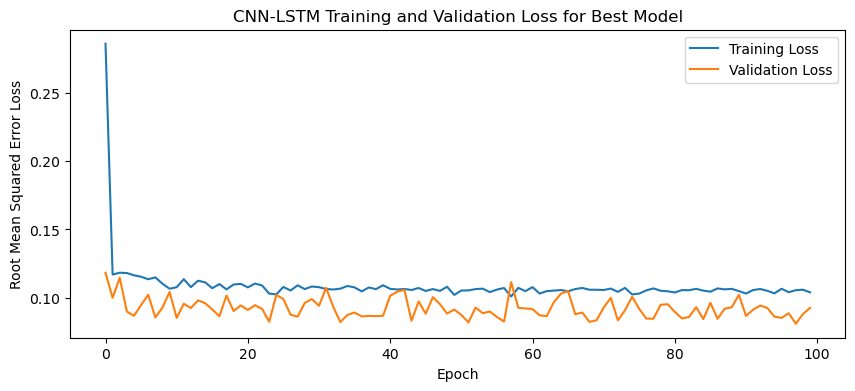

1/1 - 4s - loss: 0.0997 - 4s/epoch - 4s/step
Test Loss: 0.09966964274644852
Fold 2:
Epoch 1/100
19/19 [==============================] - 27s 461ms/step - loss: 0.2717 - val_loss: 0.1007
Epoch 2/100
19/19 [==============================] - 2s 109ms/step - loss: 0.1060 - val_loss: 0.0902
Epoch 3/100
19/19 [==============================] - 2s 94ms/step - loss: 0.1129 - val_loss: 0.1070
Epoch 4/100
19/19 [==============================] - 2s 107ms/step - loss: 0.1091 - val_loss: 0.1198
Epoch 5/100
19/19 [==============================] - 2s 103ms/step - loss: 0.1073 - val_loss: 0.0814
Epoch 6/100
19/19 [==============================] - 2s 114ms/step - loss: 0.1046 - val_loss: 0.0970
Epoch 7/100
19/19 [==============================] - 2s 94ms/step - loss: 0.1016 - val_loss: 0.0841
Epoch 8/100
19/19 [==============================] - 2s 109ms/step - loss: 0.1037 - val_loss: 0.0886
Epoch 9/100
19/19 [==============================] - 2s 103ms/step - loss: 0.1011 - val_loss: 0.0705
Epoch 10

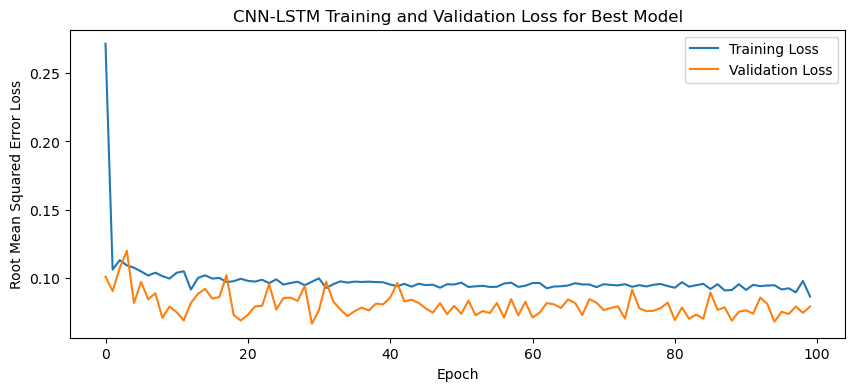

1/1 - 5s - loss: 0.0889 - 5s/epoch - 5s/step
Test Loss: 0.08887805789709091
Fold 3:
Epoch 1/100
19/19 [==============================] - 26s 479ms/step - loss: 0.2557 - val_loss: 0.1038
Epoch 2/100
19/19 [==============================] - 2s 119ms/step - loss: 0.1123 - val_loss: 0.0565
Epoch 3/100
19/19 [==============================] - 2s 118ms/step - loss: 0.1179 - val_loss: 0.0664
Epoch 4/100
19/19 [==============================] - 2s 127ms/step - loss: 0.1088 - val_loss: 0.1270
Epoch 5/100
19/19 [==============================] - 3s 188ms/step - loss: 0.1104 - val_loss: 0.0907
Epoch 6/100
19/19 [==============================] - 2s 124ms/step - loss: 0.1128 - val_loss: 0.0799
Epoch 7/100
19/19 [==============================] - 2s 121ms/step - loss: 0.1056 - val_loss: 0.1038
Epoch 8/100
19/19 [==============================] - 2s 117ms/step - loss: 0.1083 - val_loss: 0.0982
Epoch 9/100
19/19 [==============================] - 3s 174ms/step - loss: 0.1073 - val_loss: 0.0867
Epoch 

1/1 - 5s - loss: 0.0527 - 5s/epoch - 5s/step
Test Loss: 0.052715085446834564
Fold 4:
Epoch 1/100
20/20 [==============================] - 23s 461ms/step - loss: 0.2748 - val_loss: 0.0880
Epoch 2/100
20/20 [==============================] - 4s 182ms/step - loss: 0.1134 - val_loss: 0.1700
Epoch 3/100
20/20 [==============================] - 3s 149ms/step - loss: 0.0982 - val_loss: 0.1393
Epoch 4/100
20/20 [==============================] - 3s 140ms/step - loss: 0.0999 - val_loss: 0.1690
Epoch 5/100
20/20 [==============================] - 3s 160ms/step - loss: 0.1049 - val_loss: 0.1112
Epoch 6/100
20/20 [==============================] - 3s 173ms/step - loss: 0.1000 - val_loss: 0.1231
Epoch 7/100
20/20 [==============================] - 4s 178ms/step - loss: 0.0988 - val_loss: 0.1418
Epoch 8/100
20/20 [==============================] - 3s 140ms/step - loss: 0.0979 - val_loss: 0.1617
Epoch 9/100
20/20 [==============================] - 2s 124ms/step - loss: 0.0947 - val_loss: 0.1035
Epoch

1/1 - 5s - loss: 0.1098 - 5s/epoch - 5s/step
Test Loss: 0.10981009900569916
Fold 5:
Epoch 1/100
19/19 [==============================] - 28s 669ms/step - loss: 0.2775 - val_loss: 0.1666
Epoch 2/100
19/19 [==============================] - 3s 165ms/step - loss: 0.1045 - val_loss: 0.1310
Epoch 3/100
19/19 [==============================] - 3s 184ms/step - loss: 0.1035 - val_loss: 0.1308
Epoch 4/100
19/19 [==============================] - 4s 189ms/step - loss: 0.1014 - val_loss: 0.1446
Epoch 5/100
19/19 [==============================] - 5s 224ms/step - loss: 0.1014 - val_loss: 0.1472
Epoch 6/100
19/19 [==============================] - 3s 161ms/step - loss: 0.0938 - val_loss: 0.1554
Epoch 7/100
19/19 [==============================] - 3s 174ms/step - loss: 0.0973 - val_loss: 0.1072
Epoch 8/100
19/19 [==============================] - 5s 242ms/step - loss: 0.0963 - val_loss: 0.1379
Epoch 9/100
19/19 [==============================] - 6s 300ms/step - loss: 0.0954 - val_loss: 0.1538
Epoch 

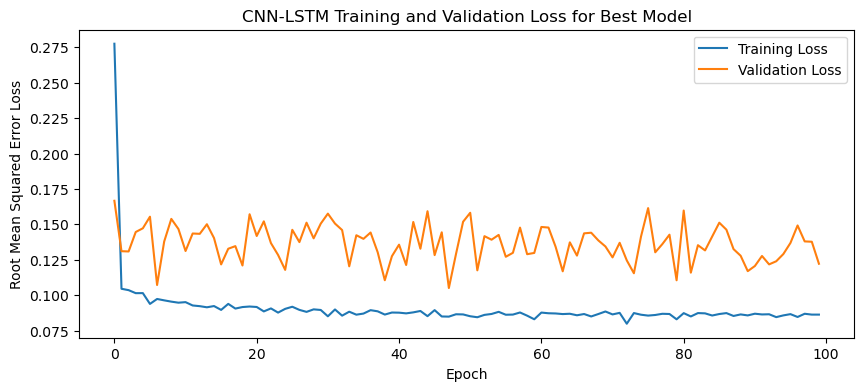

1/1 - 5s - loss: 0.0724 - 5s/epoch - 5s/step
Test Loss: 0.07237542420625687


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

In [4]:
optuna.visualization.plot_optimization_history(study)

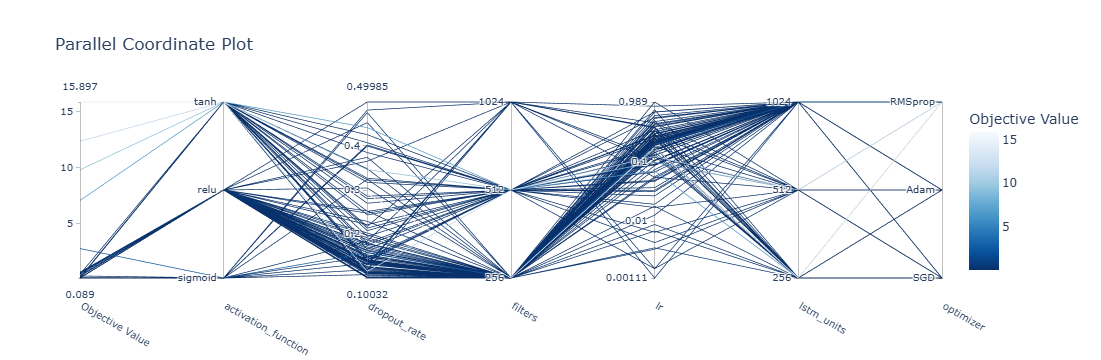

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

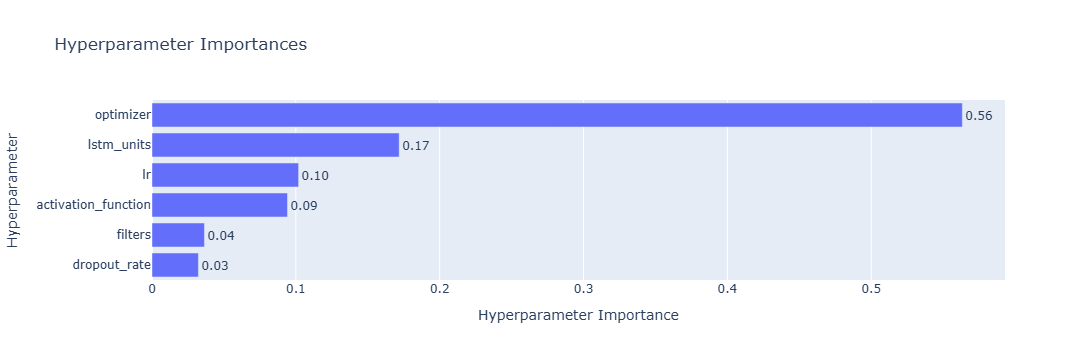

In [6]:
optuna.visualization.plot_param_importances(study)

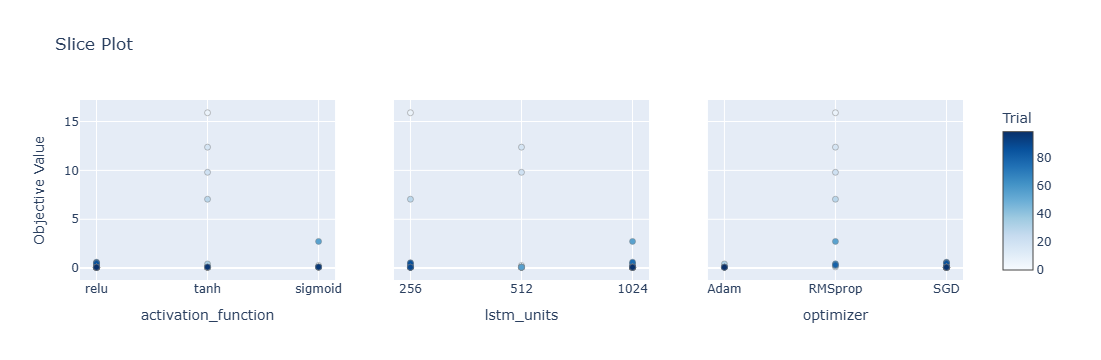

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

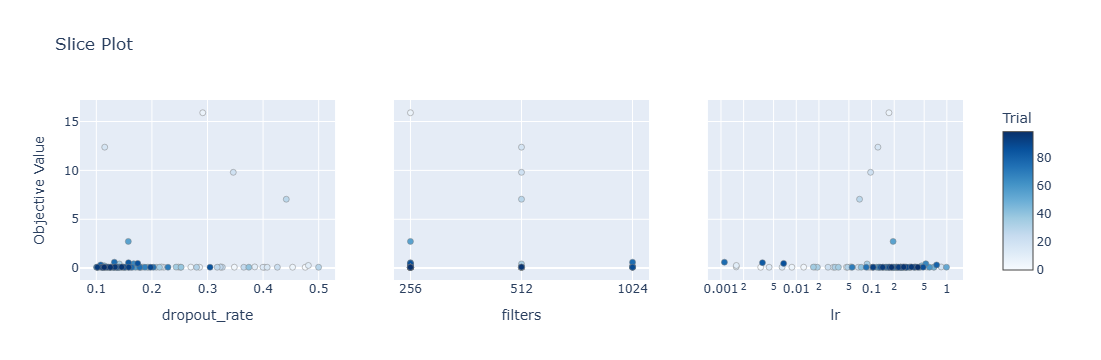

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate', 'filters'])

[[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
  19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
  21.81 22.23 22.62]
 [16.57 15.99 15.39 15.45 15.98 15.45 15.57 15.59 15.96 16.16 15.83 15.88
  15.64 16.44 17.   15.83 15.63 16.9  17.06 17.3  17.26 18.21 17.38 16.87
  17.15 16.98 18.47]]
Epoch 1/100
19/19 [==============================] - 41s 690ms/step - loss: 0.2559 - accuracy: 0.2105 - mae: 0.2346 - rmse: 0.2559 - mape: 40.9871 - pearson: 0.4073 - val_loss: 0.1147 - val_accuracy: 0.3333 - val_mae: 0.0977 - val_rmse: 0.1147 - val_mape: 17.3732 - val_pearson: 0.4406
Epoch 2/100
19/19 [==============================] - 3s 174ms/step - loss: 0.1234 - accuracy: 0.2632 - mae: 0.1012 - rmse: 0.1234 - mape: 19.3471 - pearson: 0.3948 - val_loss: 0.0798 - val_accuracy: 0.3333 - val_mae: 0.0616 - val_rmse: 0.0798 - val_mape: 11.0388 - val_pearson: 0.5919
Epoch 3/100
19/19 [==============================] - 4s 192ms/step - loss: 0.1132 - accura

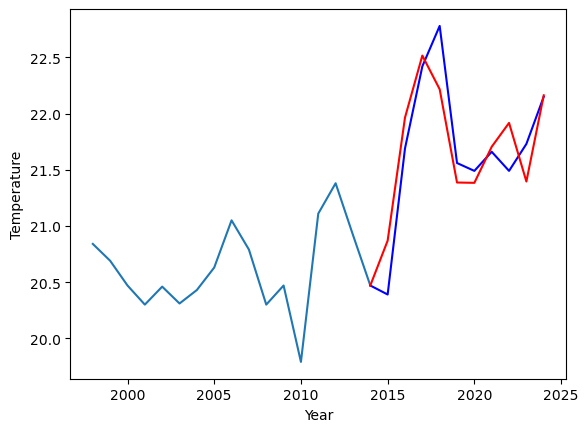

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
16.37		16.60		0.23
17.64		17.70		0.06
17.80		18.26		0.46
18.04		17.97		-0.07
18.00		17.14		-0.86
18.95		17.15		-1.80
18.12		17.47		-0.65
17.61		17.69		0.08
17.89		17.18		-0.71
17.72		17.95		0.23


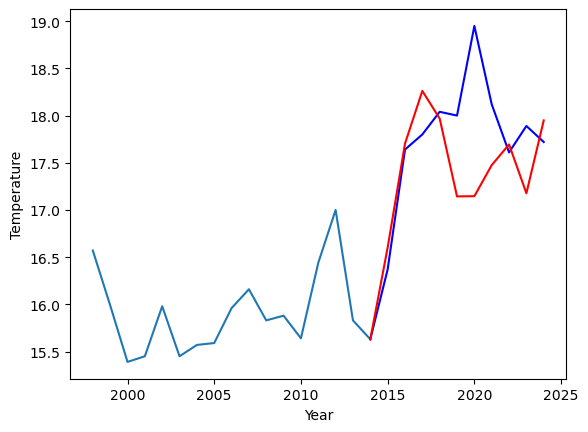

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.39  20.869207
1                1   16.37  16.601116


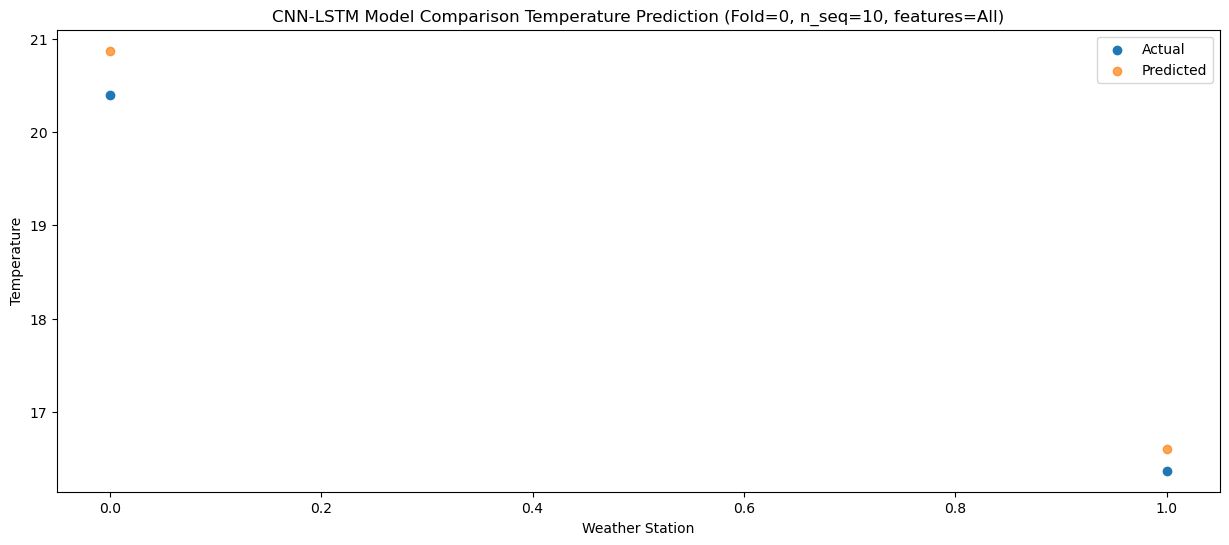

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   21.69  21.964381
1                1   17.64  17.703039


Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   22.42  22.516085
1                1   17.80  18.261508


Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   22.78  22.216445
1                1   18.04  17.968603


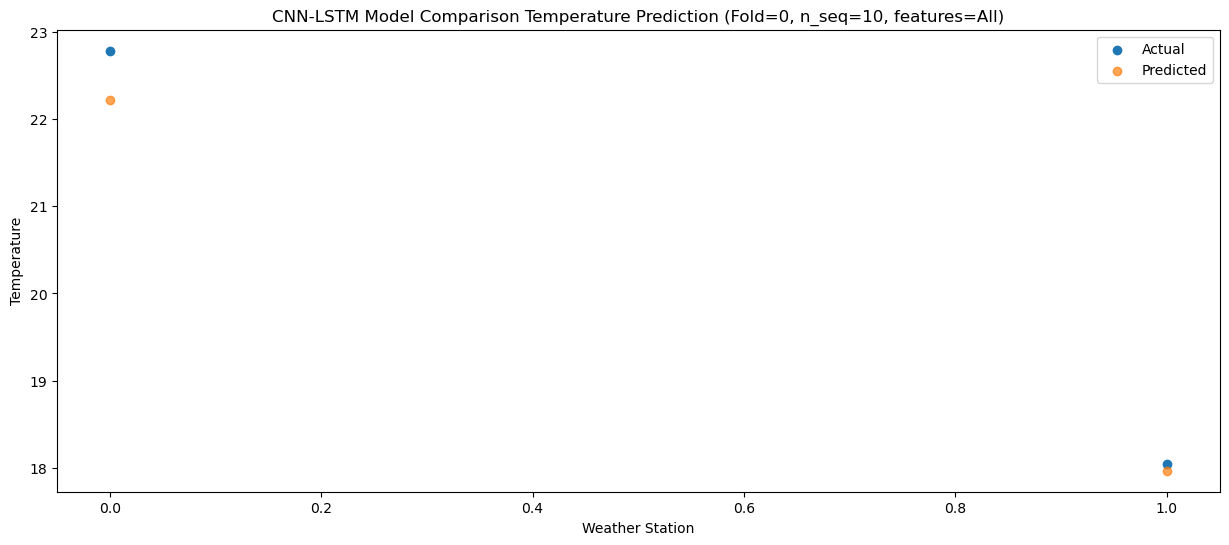

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.56  21.386475
1                1   18.00  17.143691


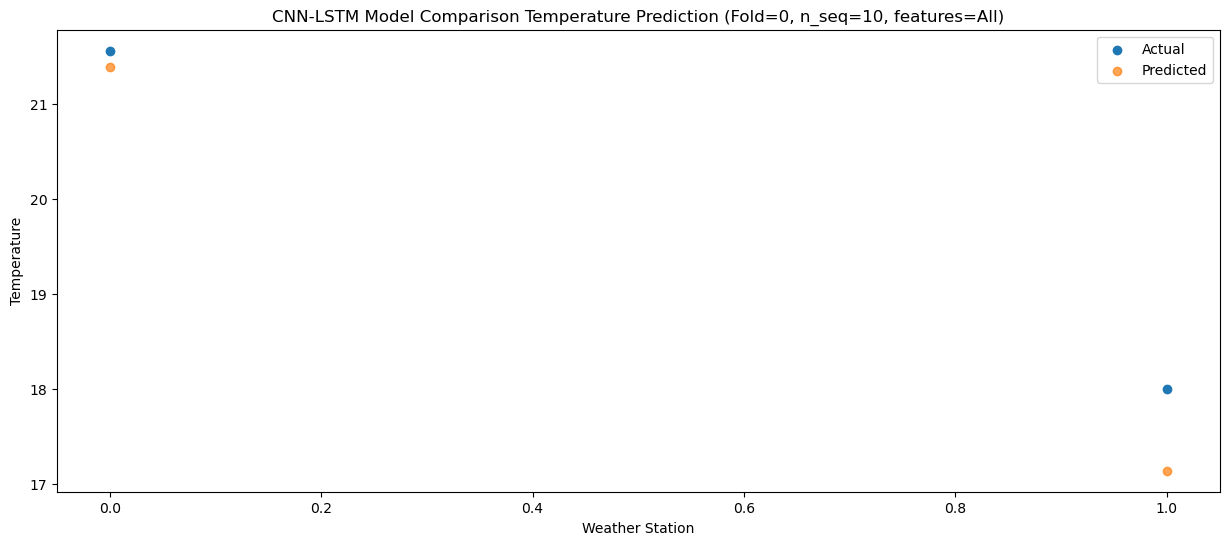

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   21.49  21.383685
1                1   18.95  17.145982


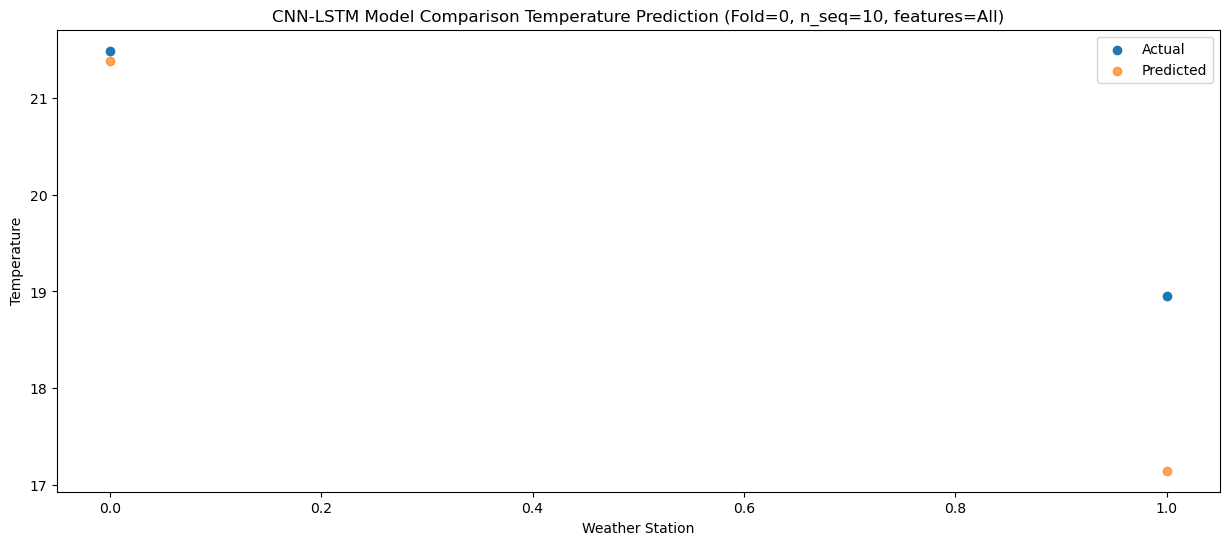

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   21.66  21.704619
1                1   18.12  17.474962


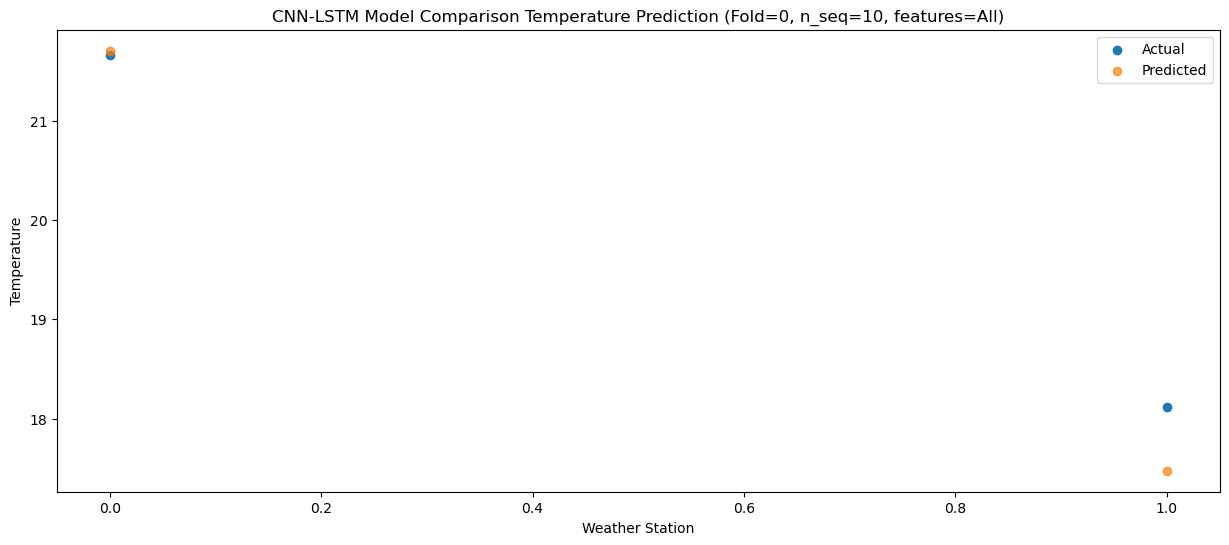

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   21.49  21.916958
1                1   17.61  17.694120


Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   21.73  21.395511
1                1   17.89  17.177064


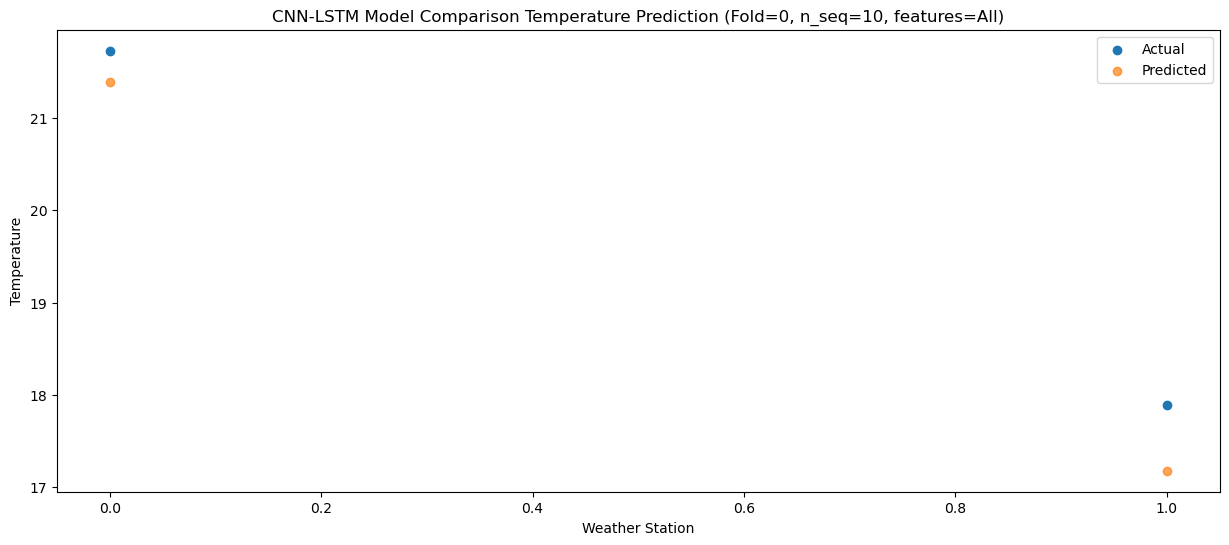

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   22.15  22.162404
1                1   17.72  17.948744


f, t:
[[20.39 16.37]
 [21.69 17.64]
 [22.42 17.8 ]
 [22.78 18.04]
 [21.56 18.  ]
 [21.49 18.95]
 [21.66 18.12]
 [21.49 17.61]
 [21.73 17.89]
 [22.15 17.72]]
[[20.86920695 16.60111621]
 [21.9643815  17.7030392 ]
 [22.51608537 18.26150825]
 [22.21644459 17.96860313]
 [21.38647513 17.14369094]
 [21.38368536 17.14598183]
 [21.70461888 17.47496204]
 [21.91695837 17.69411963]
 [21.39551125 17.17706388]
 [22.16240416 17.94874382]]
Year at t+1:
t+1 SKRMSE: 0.376201
t+1 KRMSE: 0.376201
t+1 MAE: 0.355162
t+1 SKMAPE: 0.018810
t+1 R2_SCORE: 0.964969
t+1 KMAPE: 0.018810
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.199072
t+2 KRMSE: 0.199072
t+2 MAE: 0.168710
t+2 SKMAPE: 0.008112
t+2 R2_SCORE: 0.990336
t+2 KMAPE: 0.008112
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.333333
t+3 KRMSE: 0.333333
t+3 MAE: 0.278797
t+3 SKMAPE: 0.015107
t+3 R2_SCORE: 0.979177
t+3 KMAPE: 0.015107
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.401679
t+4 KRMSE: 0.401679
t+4 MAE: 0.317476
t+4 SKMAPE: 0.014348
t+4 R

[[19.54 18.69 17.98 18.61 18.9  18.32 18.53 18.52 18.91 19.16 18.59 18.48
  18.2  19.26 19.25 18.86 18.95 19.48 19.77 19.73 19.56 19.64 19.73 18.81
  19.15 19.99 20.79]
 [19.69 19.59 19.68 19.6  19.14 19.33 18.41 19.15 20.48 18.58 19.32 19.44
  18.75 20.43 20.08 18.77 18.96 18.48 19.51 19.89 19.04 19.17 19.69 19.3
  19.3  20.61 21.9 ]]
Epoch 1/100
19/19 [==============================] - 27s 387ms/step - loss: 0.2805 - accuracy: 0.2632 - mae: 0.2623 - rmse: 0.2805 - mape: 41.6809 - pearson: 0.3599 - val_loss: 0.1098 - val_accuracy: 0.0000e+00 - val_mae: 0.0912 - val_rmse: 0.1098 - val_mape: 16.1054 - val_pearson: 0.2910
Epoch 2/100
19/19 [==============================] - 2s 84ms/step - loss: 0.1132 - accuracy: 0.2105 - mae: 0.0955 - rmse: 0.1132 - mape: 15.6859 - pearson: 0.3548 - val_loss: 0.1182 - val_accuracy: 1.0000 - val_mae: 0.0957 - val_rmse: 0.1182 - val_mape: 16.5123 - val_pearson: 0.2163
Epoch 3/100
19/19 [==============================] - 2s 95ms/step - loss: 0.1098 - accur

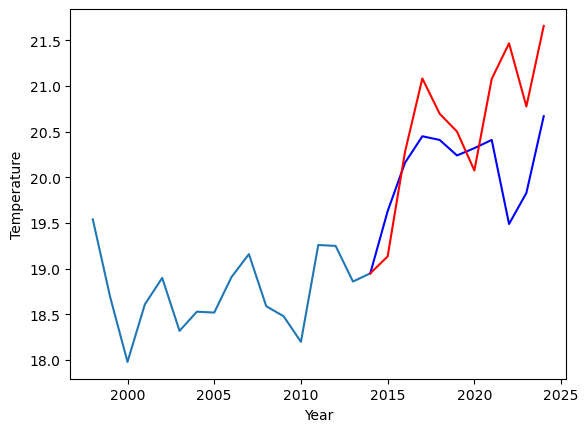

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
19.88		19.28		-0.60
19.40		20.43		1.03
20.43		21.23		0.80
20.81		20.84		0.03
19.96		20.64		0.68
20.09		20.21		0.12
20.61		21.21		0.60
20.22		21.59		1.37
20.22		20.90		0.68
21.53		21.78		0.25


Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   19.63  19.135000
1                1   19.88  19.283035


Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   20.16  20.277753
1                1   19.40  20.426080


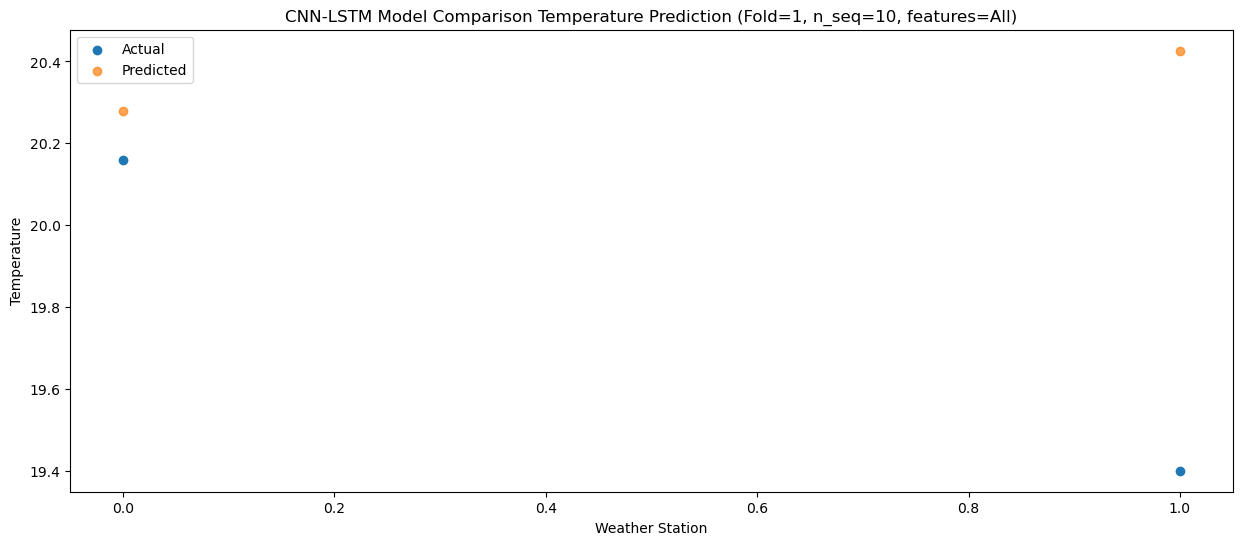

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   20.45  21.082932
1                1   20.43  21.229069


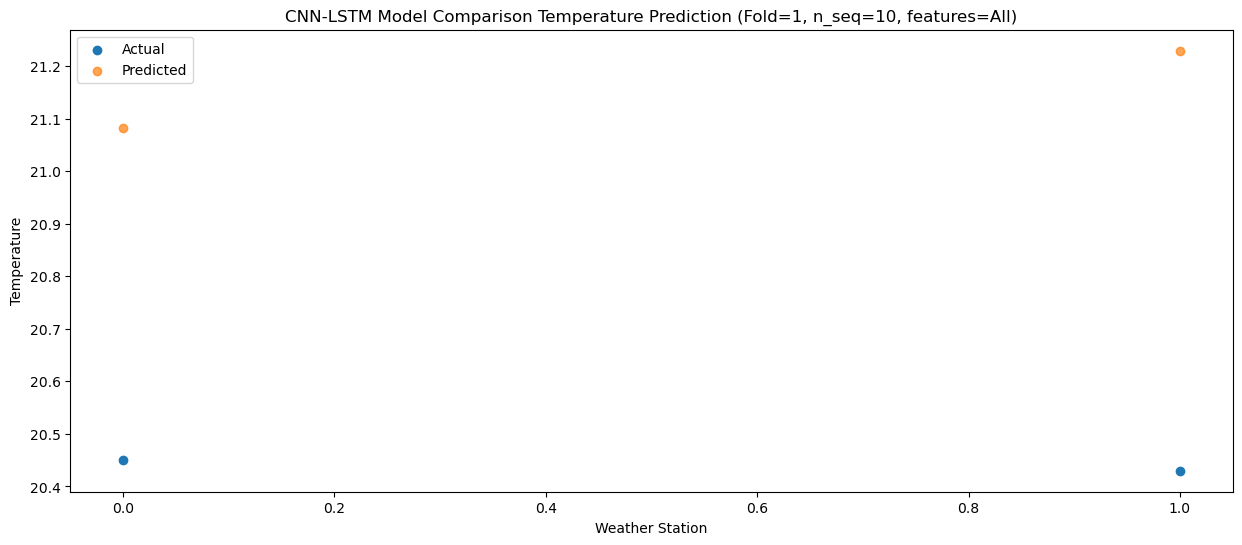

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   20.41  20.696479
1                1   20.81  20.835445


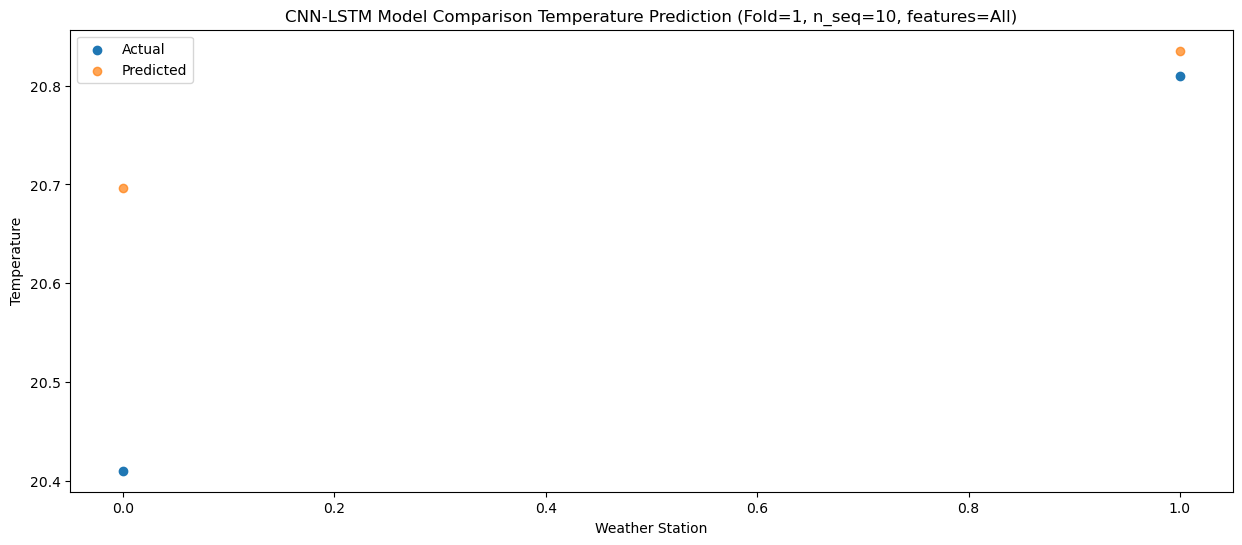

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   20.24  20.501200
1                1   19.96  20.639866


Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   20.32  20.075571
1                1   20.09  20.209333


Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   20.41  21.077684
1                1   20.61  21.208160


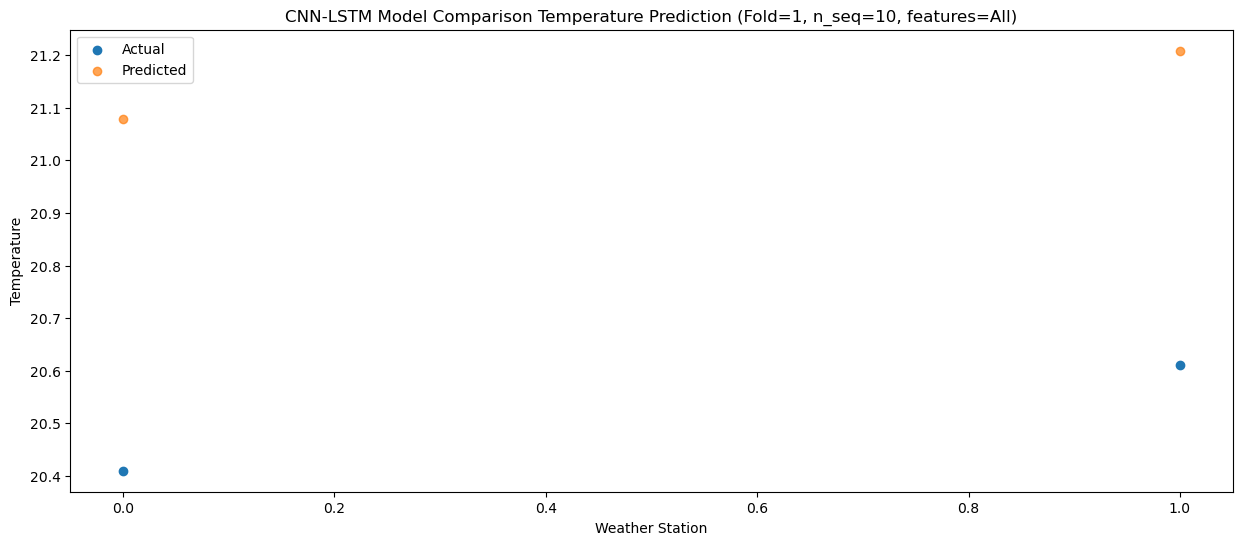

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   19.49  21.467009
1                1   20.22  21.593000


Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   19.83  20.776792
1                1   20.22  20.904109


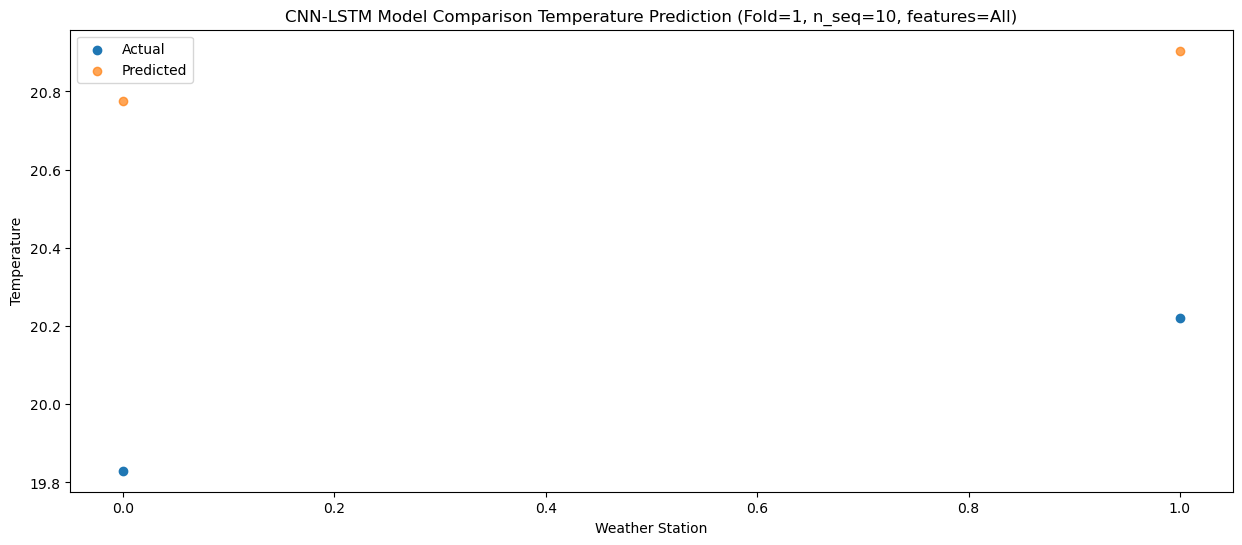

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   20.67  21.657988
1                1   21.53  21.783155


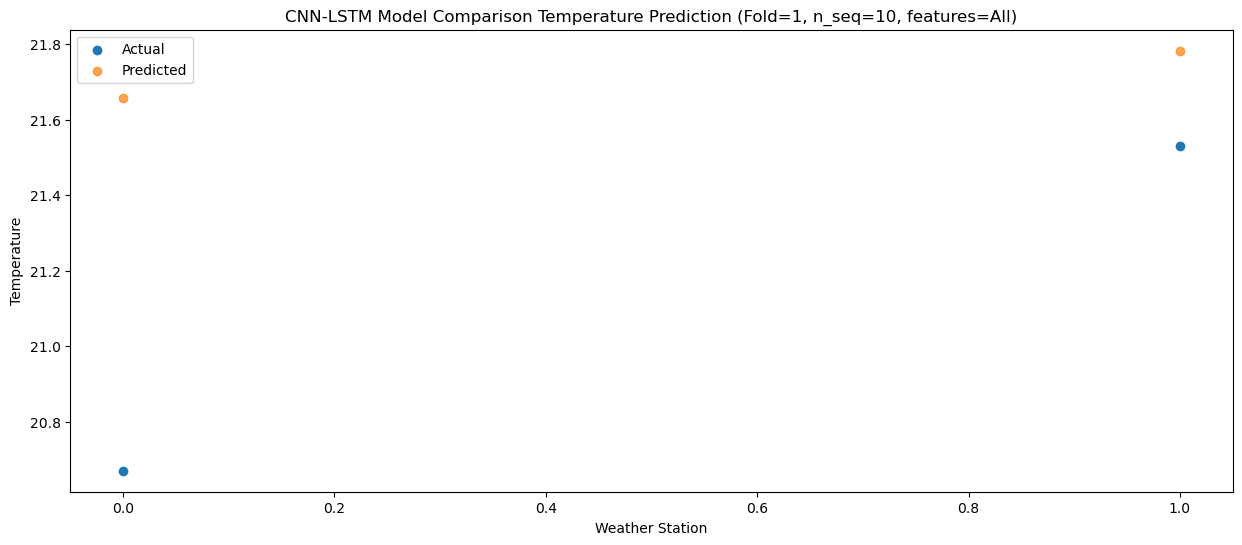

f, t:
[[19.63 19.88]
 [20.16 19.4 ]
 [20.45 20.43]
 [20.41 20.81]
 [20.24 19.96]
 [20.32 20.09]
 [20.41 20.61]
 [19.49 20.22]
 [19.83 20.22]
 [20.67 21.53]]
[[19.135      19.28303534]
 [20.27775324 20.42608029]
 [21.082932   21.22906864]
 [20.69647948 20.83544487]
 [20.50119972 20.63986551]
 [20.07557135 20.2093335 ]
 [21.07768422 21.20815994]
 [21.46700855 21.59300025]
 [20.77679177 20.90410944]
 [21.65798833 21.78315504]]
Year at t+1:
t+1 SKRMSE: 0.548357
t+1 KRMSE: 0.548357
t+1 MAE: 0.545982
t+1 SKMAPE: 0.027622
t+1 R2_SCORE: -18.244538
t+1 KMAPE: 0.027622
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.730310
t+2 KRMSE: 0.730310
t+2 MAE: 0.571917
t+2 SKMAPE: 0.029366
t+2 R2_SCORE: -2.693582
t+2 KMAPE: 0.029366
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.720803
t+3 KRMSE: 0.720803
t+3 MAE: 0.716000
t+3 SKMAPE: 0.035031
t+3 R2_SCORE: -5194.568058
t+3 KMAPE: 0.035031
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.203369
t+4 KRMSE: 0.203369
t+4 MAE: 0.155962
t+4 SKMAPE: 0.00762

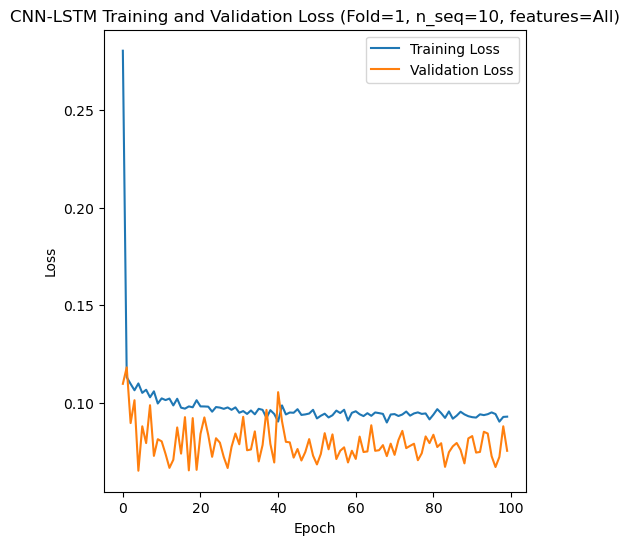

[[16.84 16.42 15.63 15.84 16.01 15.21 15.86 15.86 16.6  17.15 15.61 15.43
  15.69 16.61 16.97 15.29 15.43 16.62 17.18 16.96 16.33 17.09 16.39 16.63
  16.6  17.04 18.25]
 [13.51 12.74 11.83 12.67 12.83 11.71 12.25 12.85 13.05 13.49 12.15 12.07
  12.6  13.05 14.02 12.15 11.53 12.87 13.64 13.46 12.99 13.32 13.31 13.3
  12.84 13.63 15.32]]
Epoch 1/100
19/19 [==============================] - 43s 664ms/step - loss: 0.2807 - accuracy: 0.2632 - mae: 0.2626 - rmse: 0.2807 - mape: 41.0856 - pearson: 0.3159 - val_loss: 0.0701 - val_accuracy: 0.3333 - val_mae: 0.0597 - val_rmse: 0.0701 - val_mape: 9.2827 - val_pearson: 0.4796
Epoch 2/100
19/19 [==============================] - 3s 151ms/step - loss: 0.1049 - accuracy: 0.4211 - mae: 0.0869 - rmse: 0.1049 - mape: 14.2322 - pearson: 0.4068 - val_loss: 0.0966 - val_accuracy: 0.3333 - val_mae: 0.0751 - val_rmse: 0.0966 - val_mape: 12.4333 - val_pearson: 0.5858
Epoch 3/100
19/19 [==============================] - 3s 147ms/step - loss: 0.1098 - accuracy

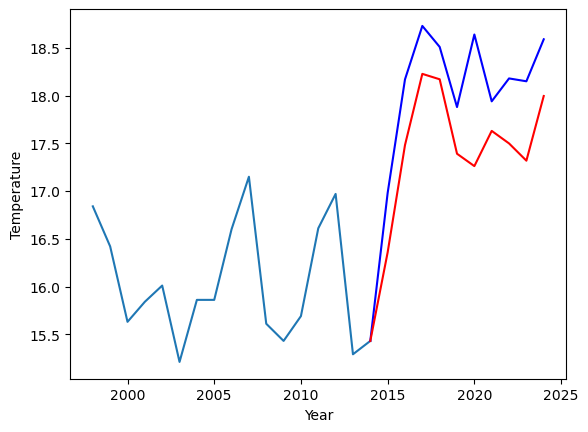

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.89		13.03		0.14
14.23		14.17		-0.06
15.00		14.92		-0.08
14.82		14.86		0.04
14.35		14.09		-0.26
14.68		13.96		-0.72
14.67		14.33		-0.34
14.66		14.20		-0.46
14.20		14.03		-0.17
14.99		14.71		-0.28


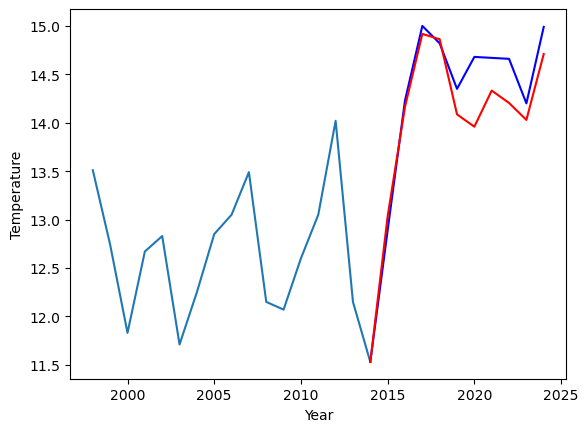

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   16.98  16.357570
1                1   12.89  13.033455


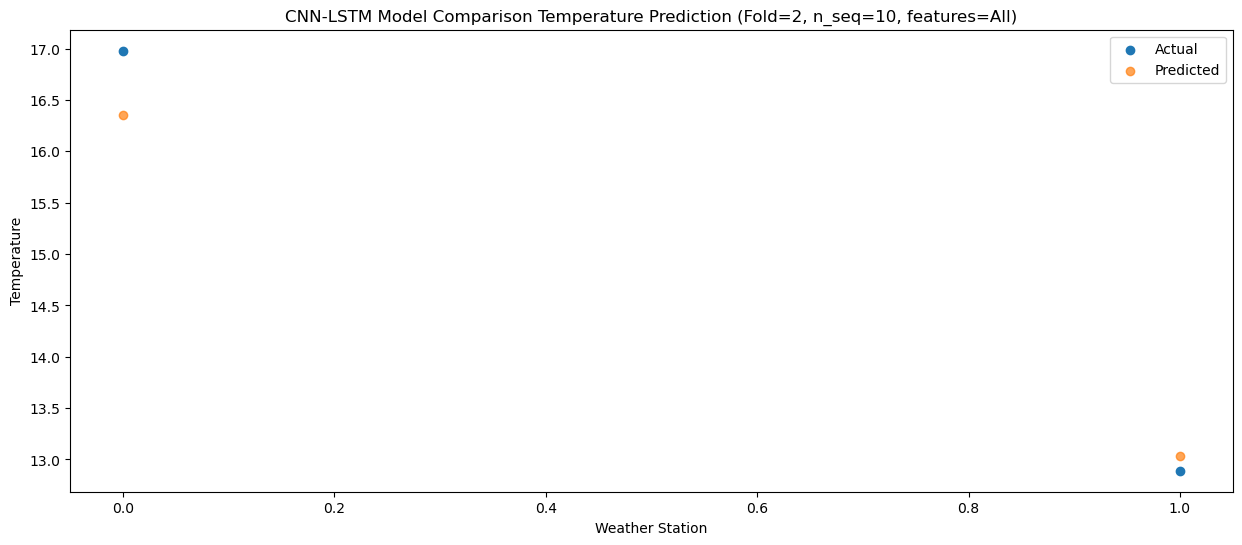

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   18.17  17.481549
1                1   14.23  14.165506


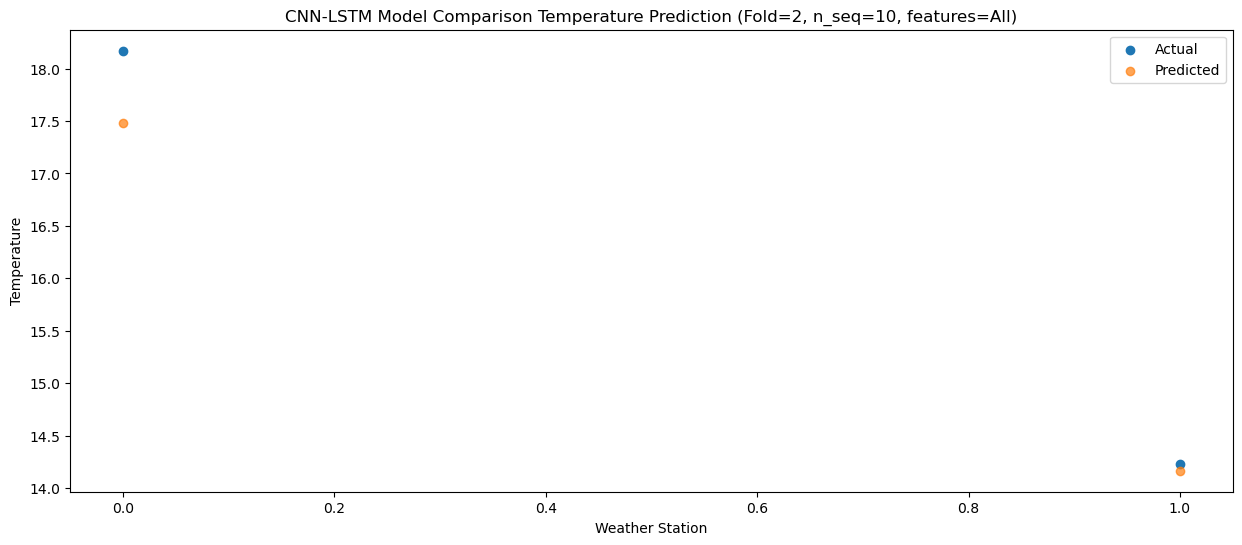

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   18.73  18.227656
1                1   15.00  14.917624


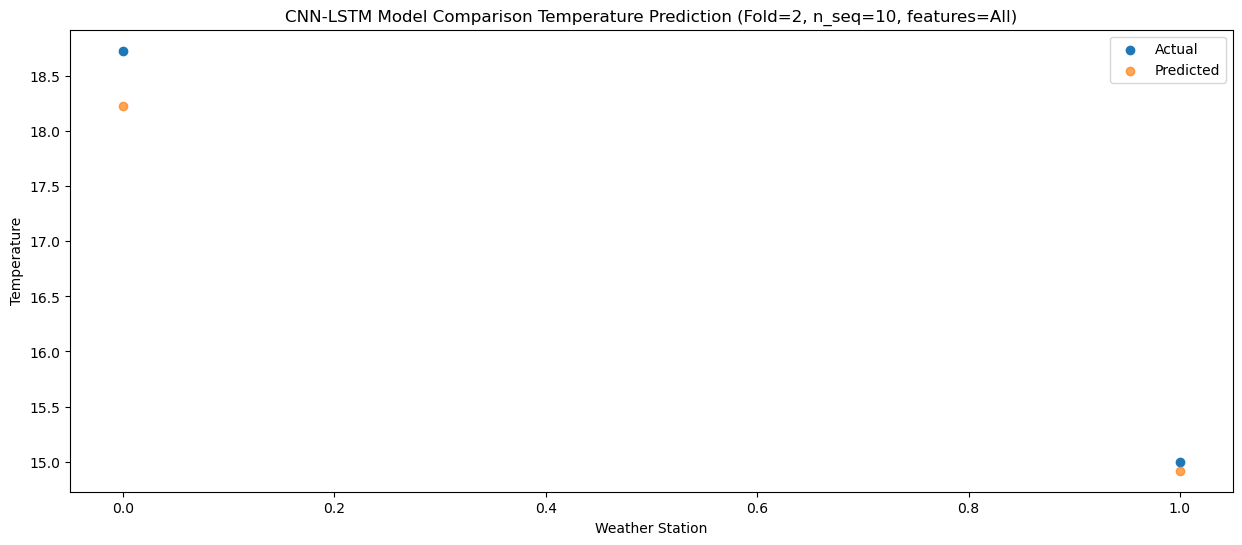

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   18.51  18.170924
1                1   14.82  14.862506


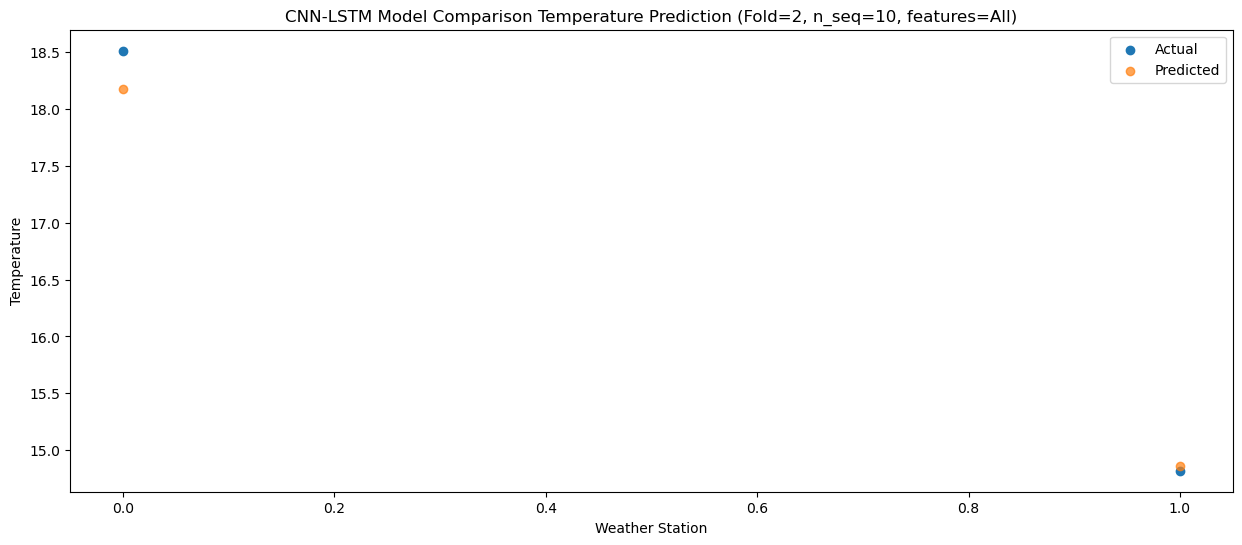

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   17.88  17.390929
1                1   14.35  14.086521


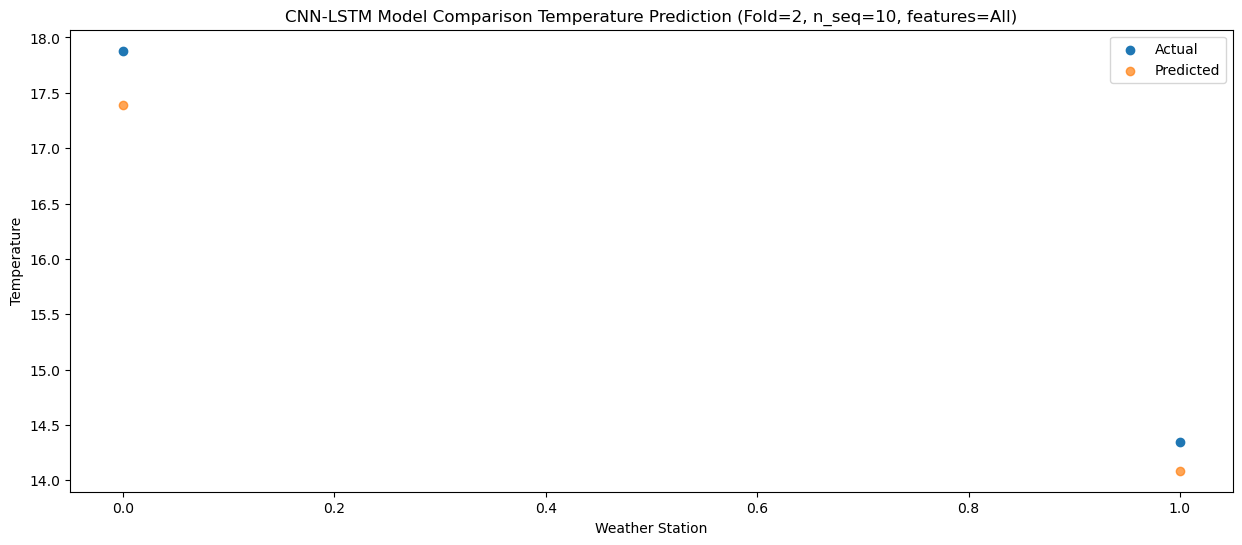

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   18.64  17.261371
1                1   14.68  13.958999


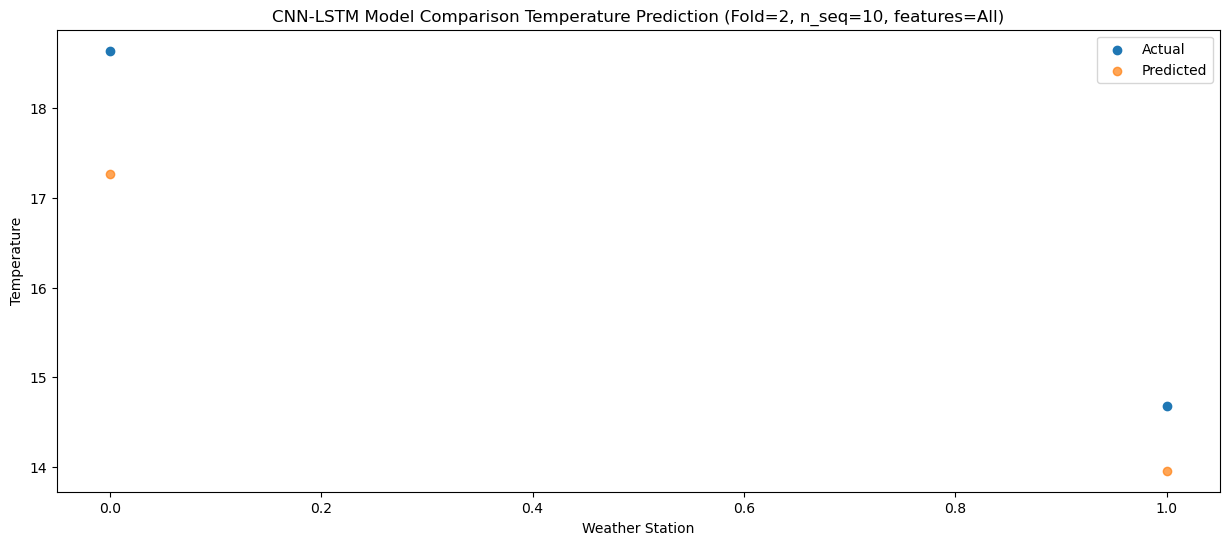

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   17.94  17.630343
1                1   14.67  14.332457


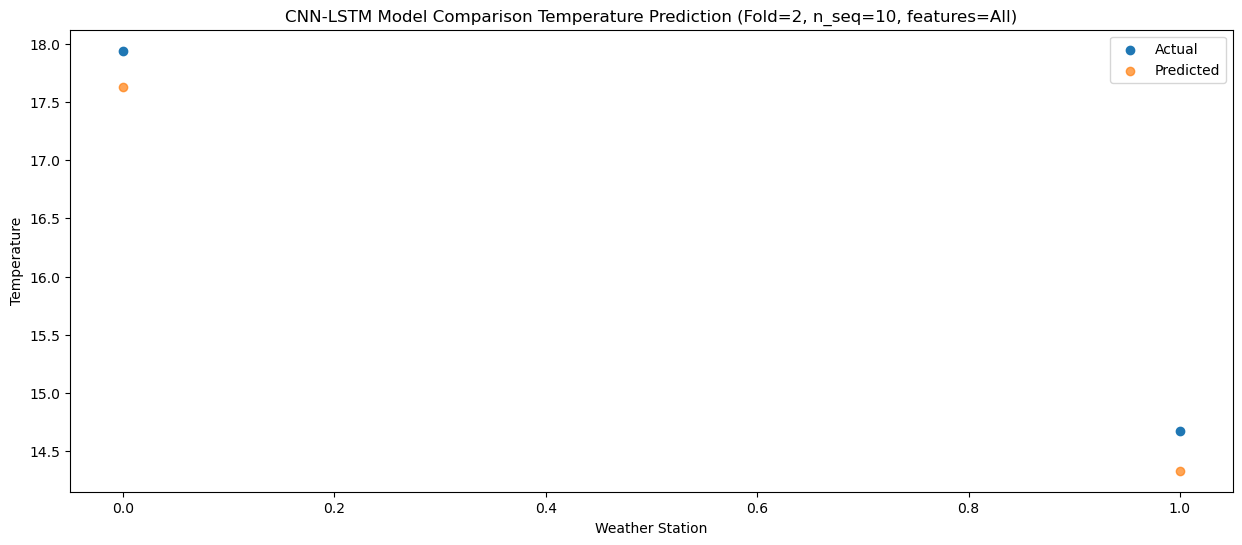

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   18.18  17.499020
1                1   14.66  14.204334


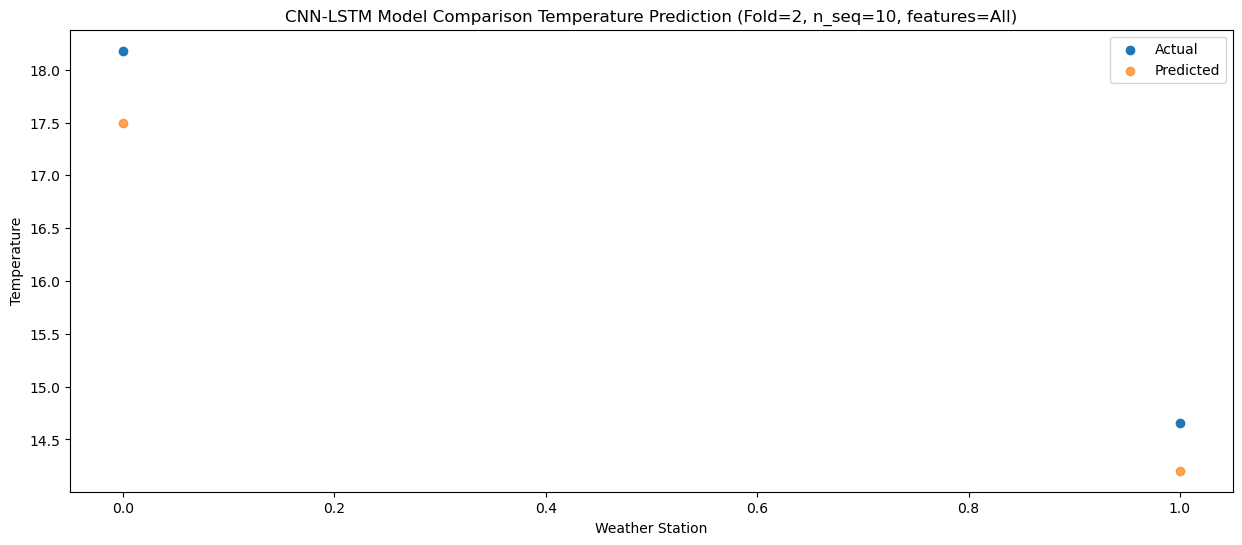

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   18.15  17.318301
1                1   14.20  14.029448


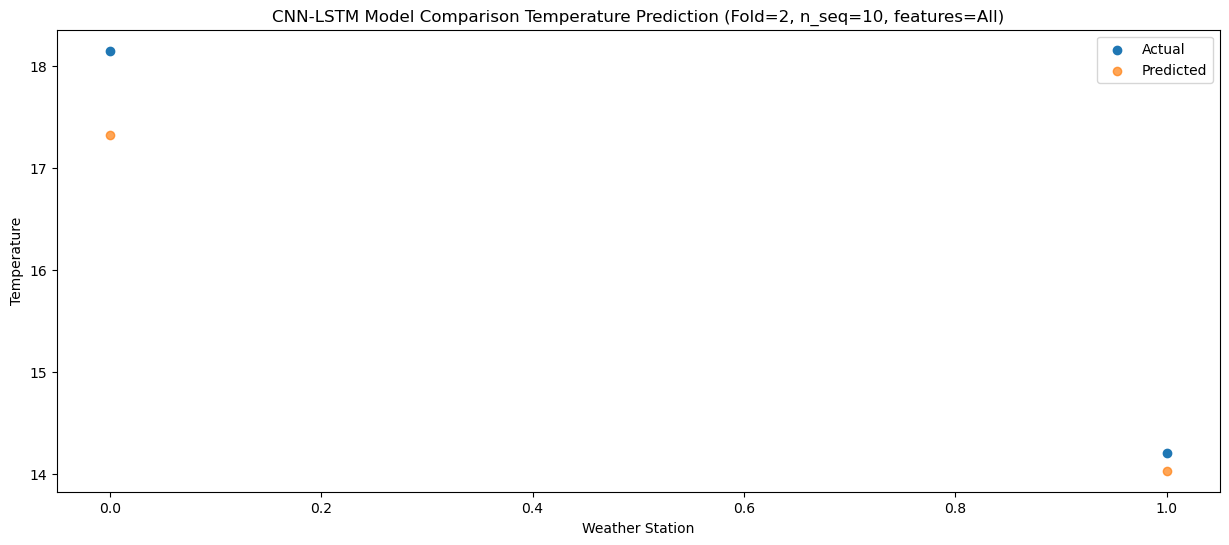

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   18.59  17.995735
1                1   14.99  14.709667


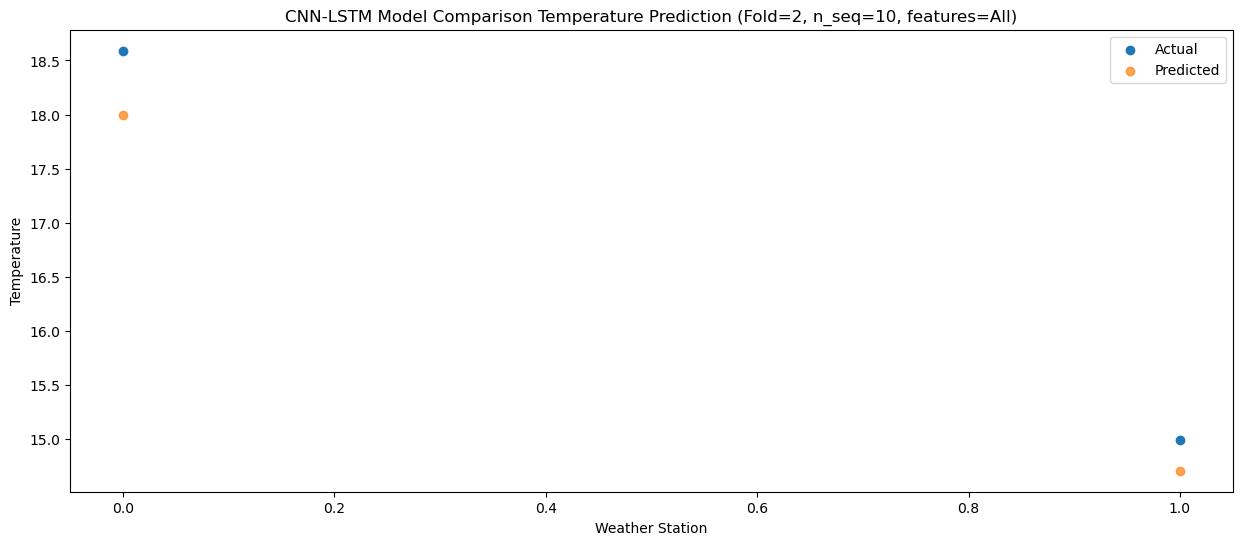

f, t:
[[16.98 12.89]
 [18.17 14.23]
 [18.73 15.  ]
 [18.51 14.82]
 [17.88 14.35]
 [18.64 14.68]
 [17.94 14.67]
 [18.18 14.66]
 [18.15 14.2 ]
 [18.59 14.99]]
[[16.35756984 13.03345496]
 [17.48154905 14.16550596]
 [18.22765585 14.91762377]
 [18.17092387 14.86250647]
 [17.3909292  14.08652087]
 [17.26137107 13.95899871]
 [17.63034274 14.33245734]
 [17.49902012 14.20433387]
 [17.31830106 14.02944832]
 [17.99573467 14.70966689]]
Year at t+1:
t+1 SKRMSE: 0.451663
t+1 KRMSE: 0.451663
t+1 MAE: 0.382943
t+1 SKMAPE: 0.023893
t+1 R2_SCORE: 0.951220
t+1 KMAPE: 0.023893
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.488940
t+2 KRMSE: 0.488940
t+2 MAE: 0.376472
t+2 SKMAPE: 0.021211
t+2 R2_SCORE: 0.938400
t+2 KMAPE: 0.021211
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.359955
t+3 KRMSE: 0.359955
t+3 MAE: 0.292360
t+3 SKMAPE: 0.016156
t+3 R2_SCORE: 0.962749
t+3 KMAPE: 0.016156
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.241640
t+4 KRMSE: 0.241640
t+4 MAE: 0.190791
t+4 SKMAPE: 0.010593
t+4 R

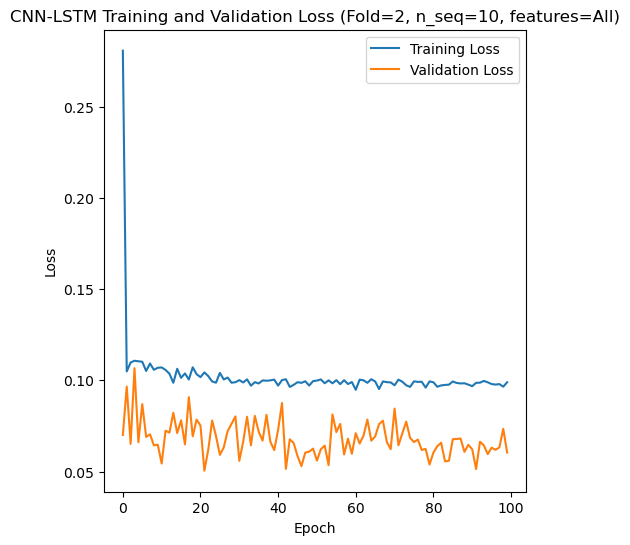

[[14.79 16.53 17.4  17.93 17.46 17.79 17.15 17.27 16.83 16.99 17.41 16.9
  16.66 16.28 17.66 17.63 19.01 18.49 18.19 18.12 18.2  17.83 17.88 18.2
  18.19 17.9  20.04]
 [14.06 13.64 12.62 13.34 13.58 12.56 13.34 13.7  13.71 13.89 12.74 12.51
  12.94 13.34 14.11 12.94 11.91 13.01 14.3  14.13 13.64 14.05 13.93 13.73
  13.43 14.45 16.49]]
Epoch 1/100
20/20 [==============================] - 41s 628ms/step - loss: 0.2811 - accuracy: 0.3500 - mae: 0.2629 - rmse: 0.2811 - mape: 39.9273 - pearson: 0.2642 - val_loss: 0.1549 - val_accuracy: 0.0000e+00 - val_mae: 0.1173 - val_rmse: 0.1549 - val_mape: 17.2336 - val_pearson: 0.4344
Epoch 2/100
20/20 [==============================] - 4s 184ms/step - loss: 0.1068 - accuracy: 0.3000 - mae: 0.0888 - rmse: 0.1068 - mape: 14.2884 - pearson: 0.3444 - val_loss: 0.1752 - val_accuracy: 1.0000 - val_mae: 0.1448 - val_rmse: 0.1752 - val_mape: 23.3612 - val_pearson: 0.2143
Epoch 3/100
20/20 [==============================] - 3s 161ms/step - loss: 0.0999 - accu

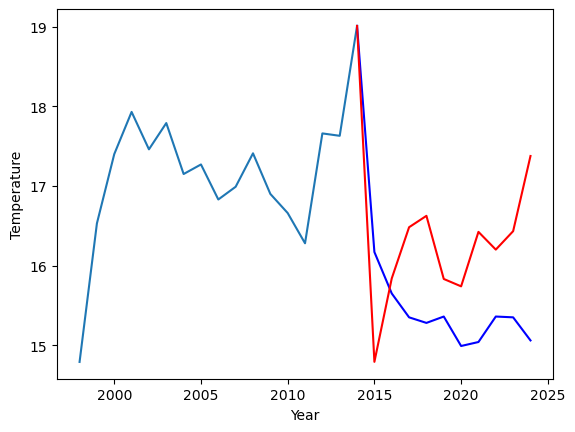

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.03		14.06		1.03
14.13		15.11		0.98
15.42		15.76		0.34
15.25		15.92		0.67
14.76		15.13		0.37
15.17		15.04		-0.13
15.05		15.73		0.68
14.85		15.51		0.66
14.55		15.73		1.18
15.57		16.68		1.11


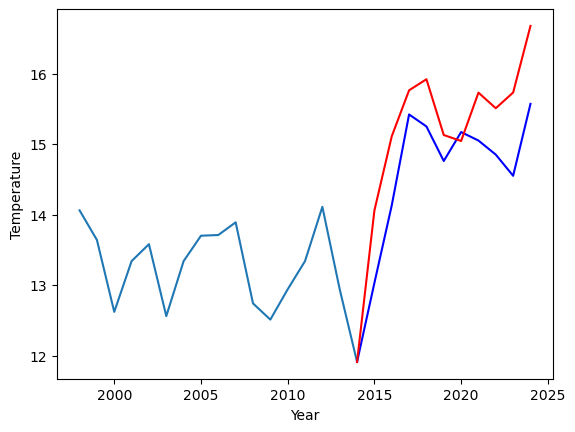

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   16.17  14.791158
1                1   13.03  14.057731


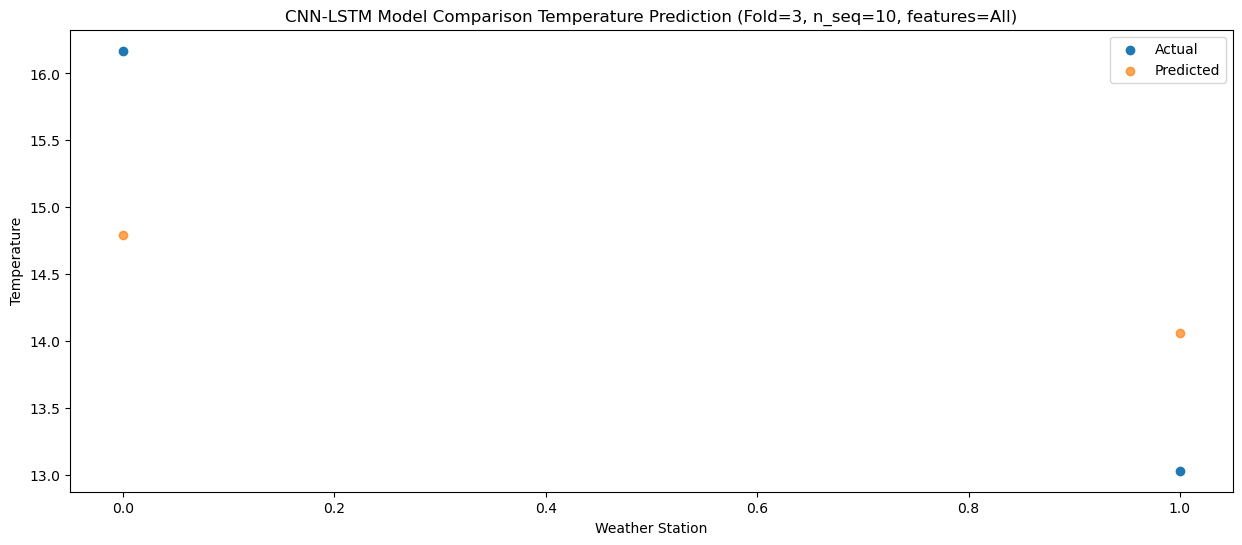

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   15.65  15.838327
1                1   14.13  15.109914


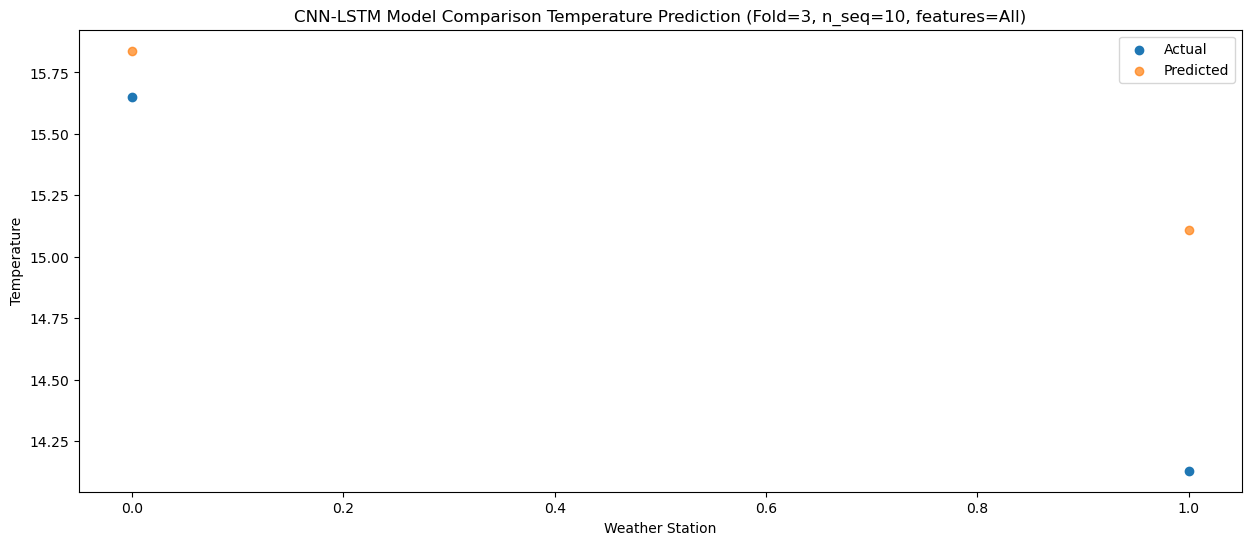

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   15.35  16.481709
1                1   15.42  15.762666


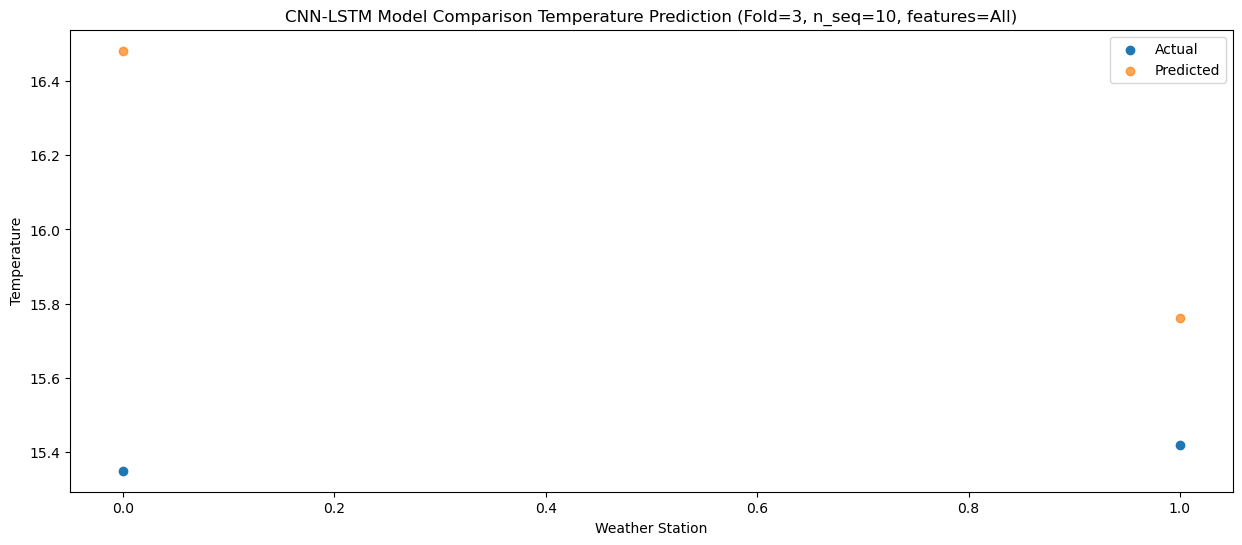

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   15.28  16.624771
1                1   15.25  15.919291


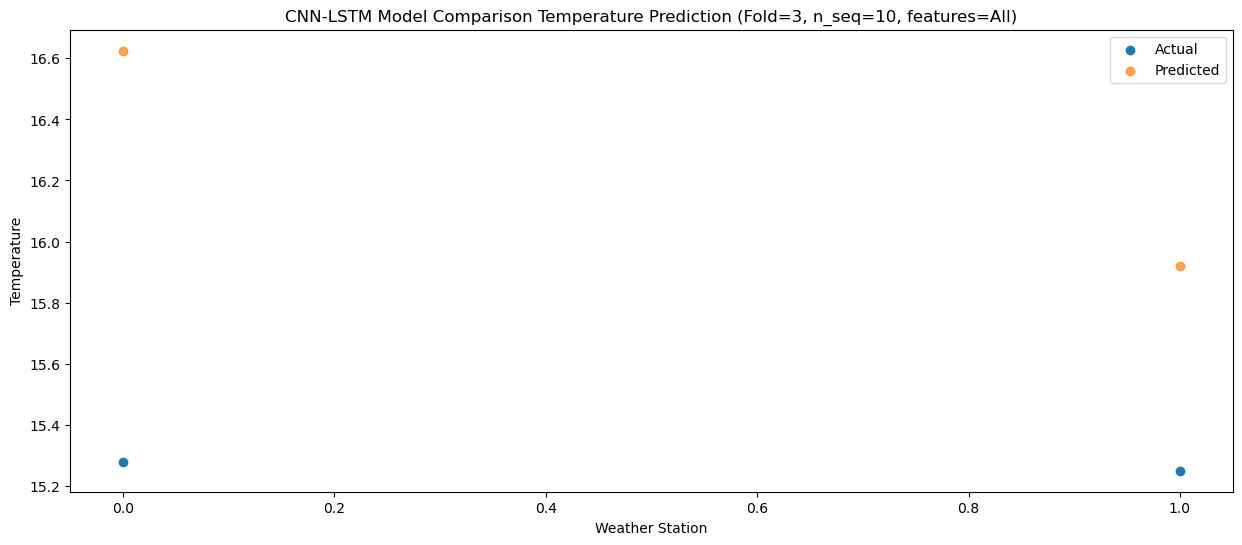

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   15.36  15.831924
1                1   14.76  15.128172


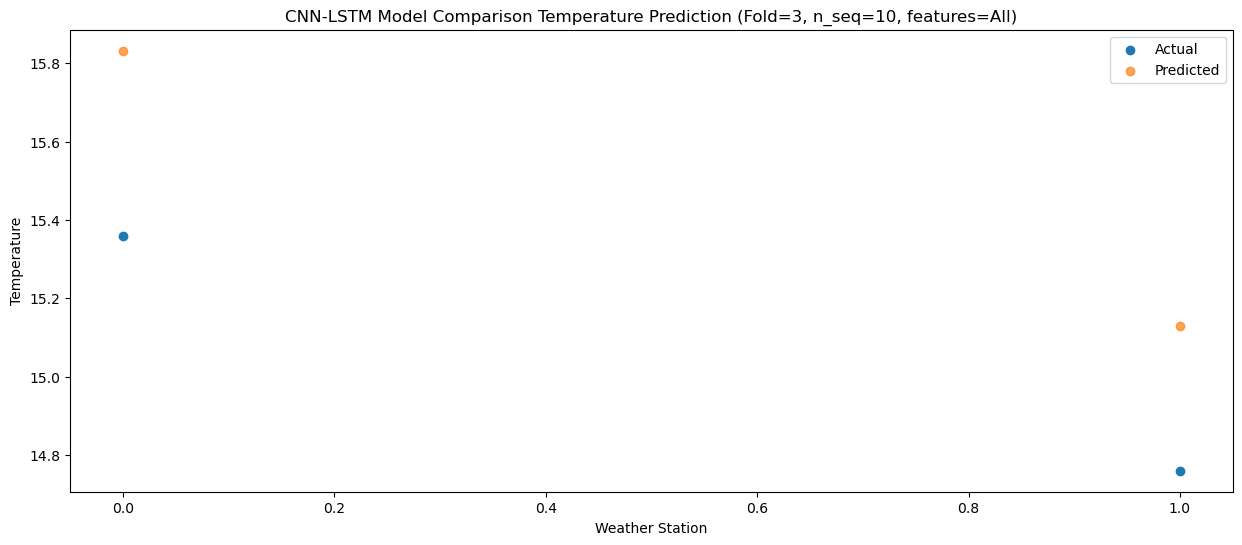

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   14.99  15.739212
1                1   15.17  15.043683


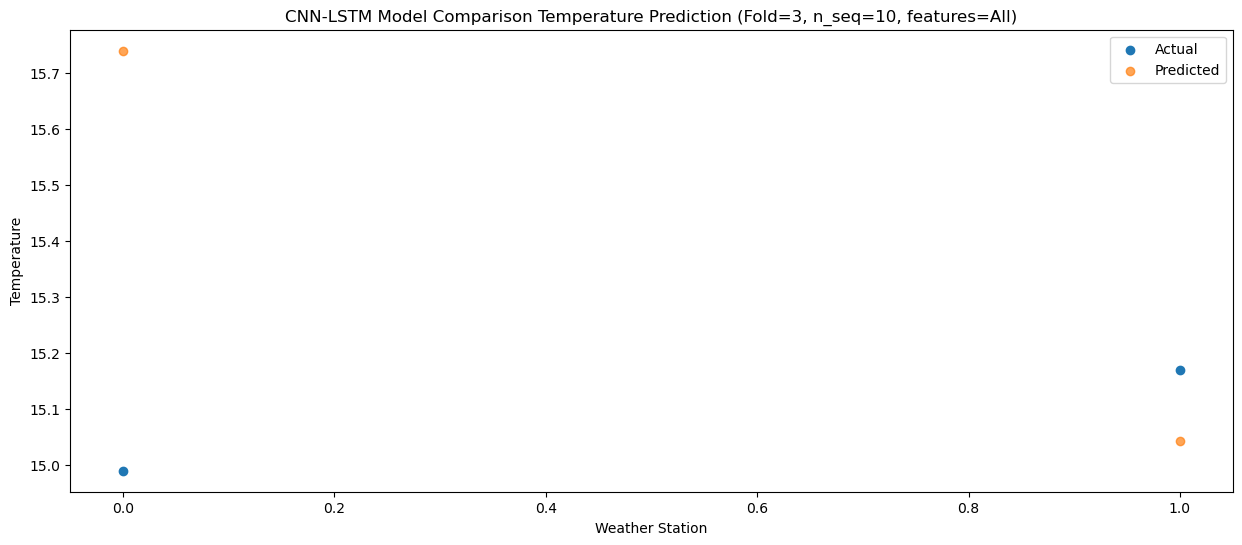

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   15.04  16.423424
1                1   15.05  15.729366


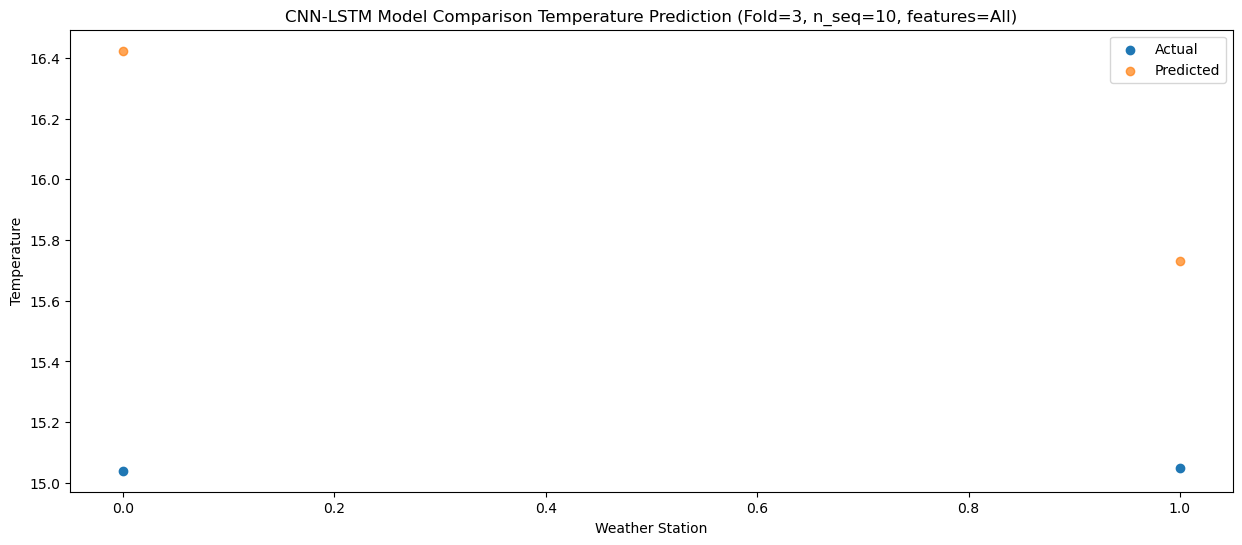

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   15.36  16.200677
1                1   14.85  15.508282


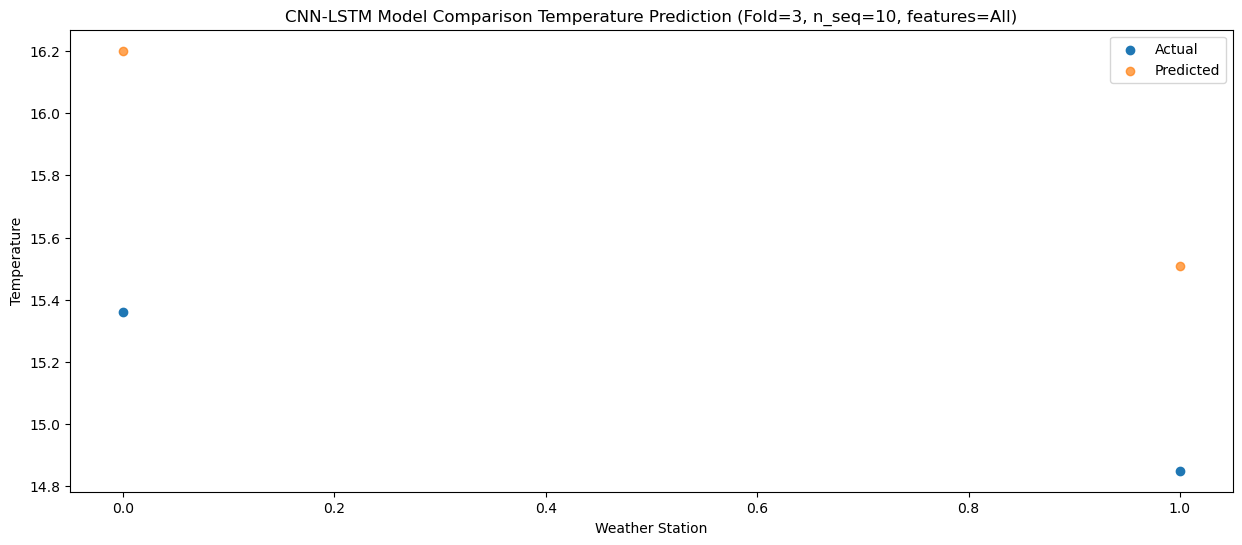

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   15.35  16.432249
1                1   14.55  15.731174


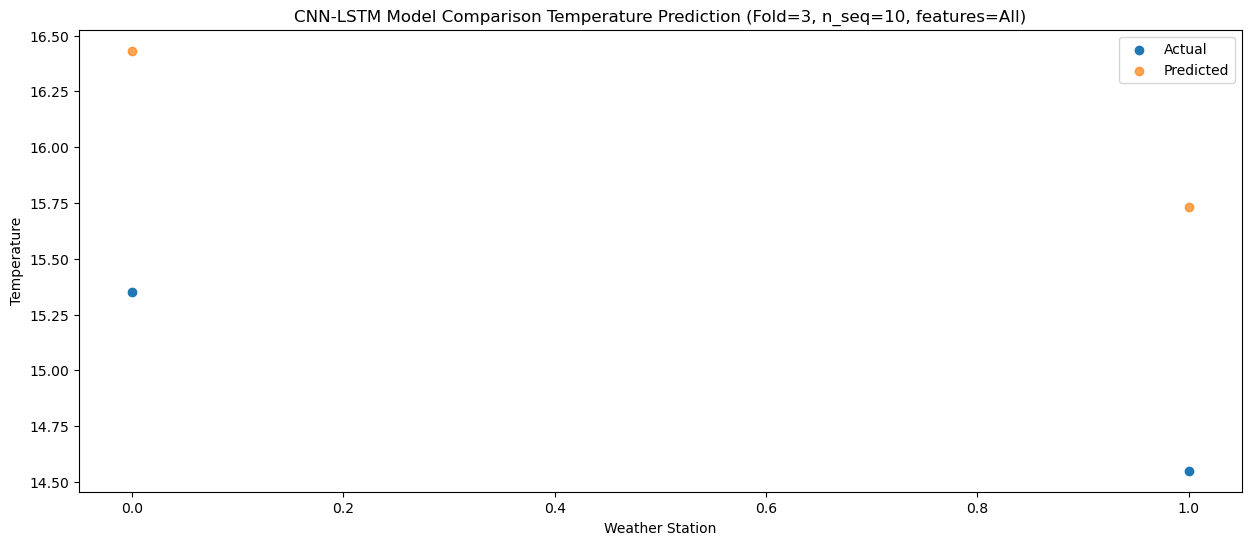

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   15.06  17.376135
1                1   15.57  16.675749


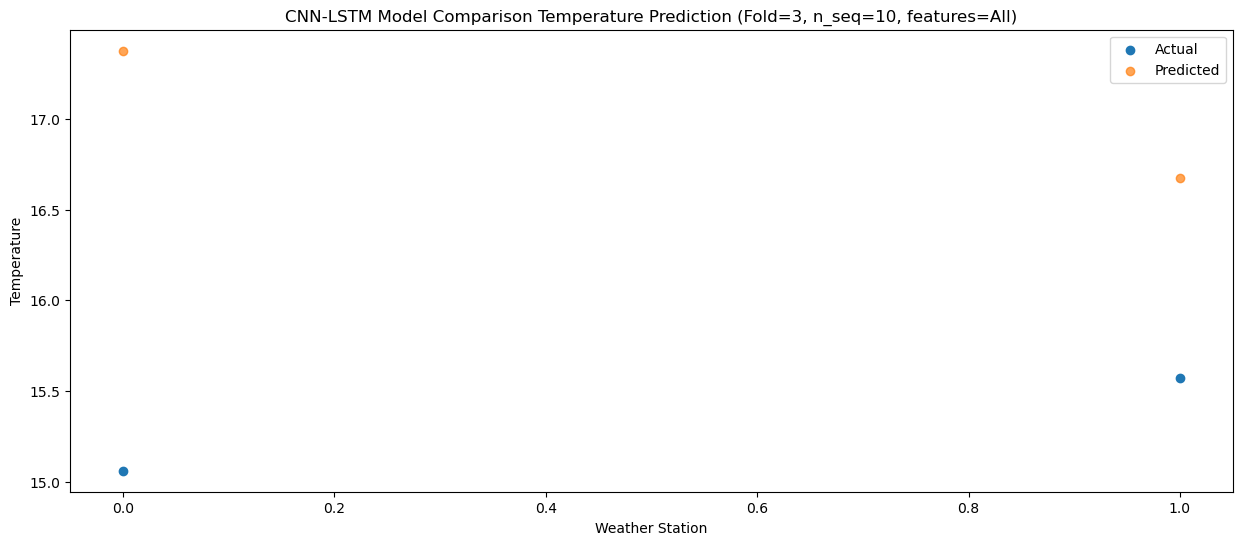

f, t:
[[16.17 13.03]
 [15.65 14.13]
 [15.35 15.42]
 [15.28 15.25]
 [15.36 14.76]
 [14.99 15.17]
 [15.04 15.05]
 [15.36 14.85]
 [15.35 14.55]
 [15.06 15.57]]
[[14.79115787 14.05773096]
 [15.83832684 15.10991447]
 [16.48170861 15.76266627]
 [16.62477134 15.91929072]
 [15.83192383 15.12817186]
 [15.73921194 15.04368253]
 [16.42342438 15.72936626]
 [16.20067719 15.50828167]
 [16.43224863 15.73117376]
 [17.37613533 16.67574865]]
Year at t+1:
t+1 SKRMSE: 1.216026
t+1 KRMSE: 1.216026
t+1 MAE: 1.203287
t+1 SKMAPE: 0.082073
t+1 R2_SCORE: 0.400090
t+1 KMAPE: 0.082073
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.705585
t+2 KRMSE: 0.705585
t+2 MAE: 0.584121
t+2 SKMAPE: 0.040692
t+2 R2_SCORE: 0.138072
t+2 KMAPE: 0.040692
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.836117
t+3 KRMSE: 0.836117
t+3 MAE: 0.737187
t+3 SKMAPE: 0.047975
t+3 R2_SCORE: -569.687577
t+3 KMAPE: 0.047975
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 1.062158
t+4 KRMSE: 1.062158
t+4 MAE: 1.007031
t+4 SKMAPE: 0.065948
t+

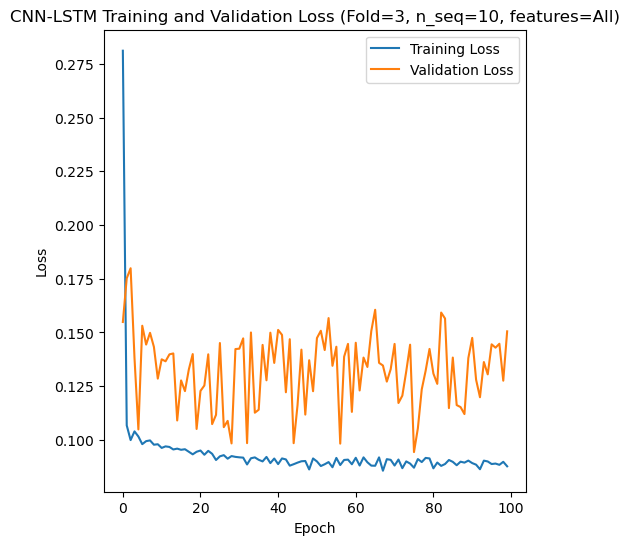

[[21.14 18.96 18.26 17.93 17.59 18.09 18.   18.94 19.77 18.17 18.51 17.84
  17.96 19.05 19.41 17.5  17.5  18.37 18.89 19.09 18.25 18.12 18.64 18.22
  18.72 19.65 20.58]
 [12.93 12.18 11.5  12.1  11.94 11.27 11.81 12.49 12.65 12.57 10.89 11.63
  12.44 12.56 14.1  11.08 10.78 12.73 13.75 13.68 12.38 11.68 12.24 12.56
  11.69 13.17 14.51]]
Epoch 1/100
19/19 [==============================] - 35s 481ms/step - loss: 0.2573 - accuracy: 0.2105 - mae: 0.2394 - rmse: 0.2573 - mape: 37.9139 - pearson: 0.2465 - val_loss: 0.1147 - val_accuracy: 1.0000 - val_mae: 0.0969 - val_rmse: 0.1147 - val_mape: 16.1017 - val_pearson: 0.6083
Epoch 2/100
19/19 [==============================] - 2s 99ms/step - loss: 0.1035 - accuracy: 0.3158 - mae: 0.0840 - rmse: 0.1035 - mape: 13.9221 - pearson: 0.3516 - val_loss: 0.1725 - val_accuracy: 0.0000e+00 - val_mae: 0.1480 - val_rmse: 0.1725 - val_mape: 25.7233 - val_pearson: 0.1308
Epoch 3/100
19/19 [==============================] - 2s 101ms/step - loss: 0.0971 - acc

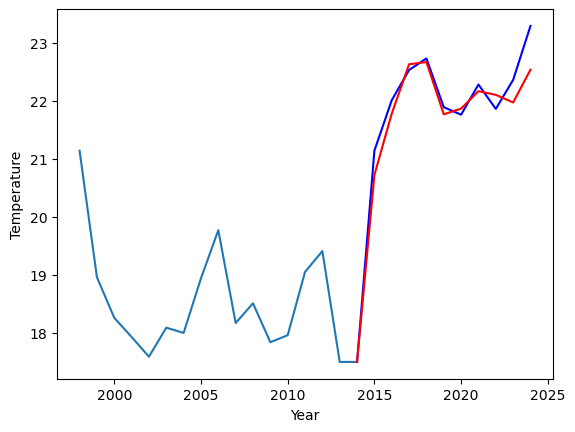

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.63		12.49		-0.14
14.58		13.57		-1.01
15.60		14.45		-1.15
15.53		14.49		-1.04
14.23		13.61		-0.62
13.53		13.74		0.21
14.09		14.06		-0.03
14.41		14.03		-0.38
13.54		13.89		0.35
15.02		14.46		-0.56


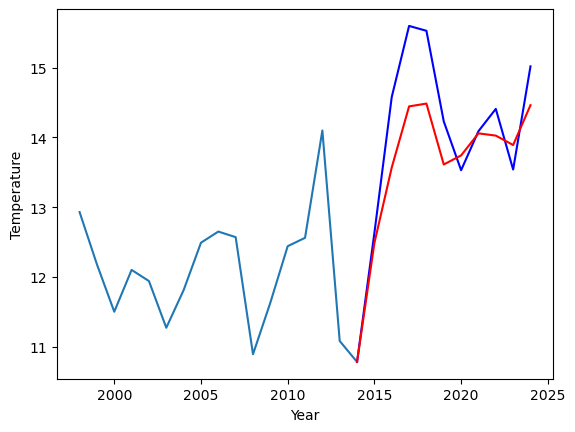

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   21.14  20.721822
1                1   12.63  12.486301


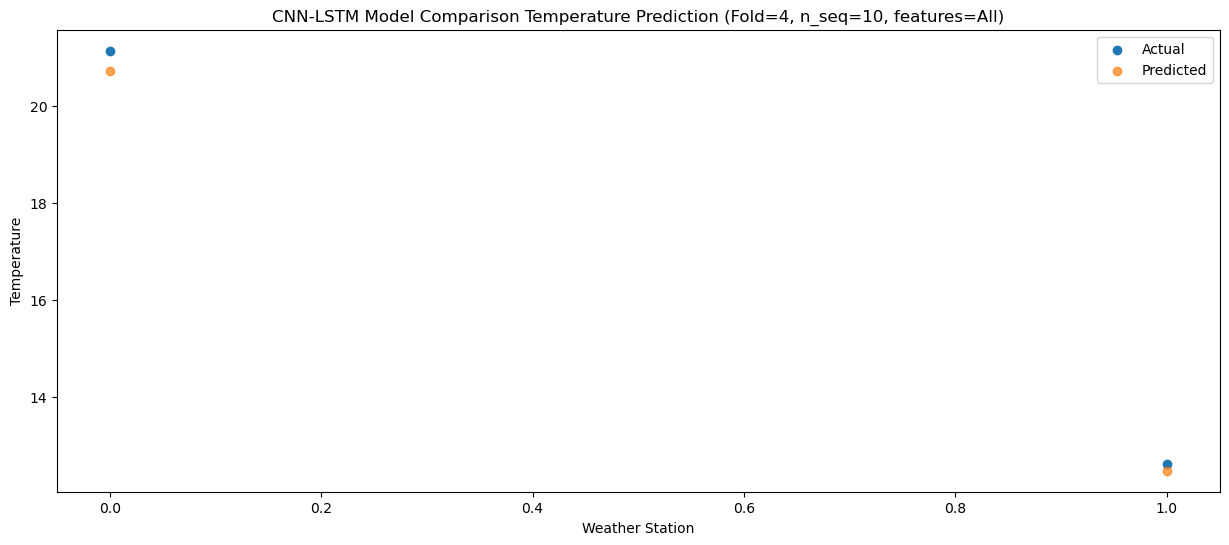

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   22.01  21.778088
1                1   14.58  13.568379


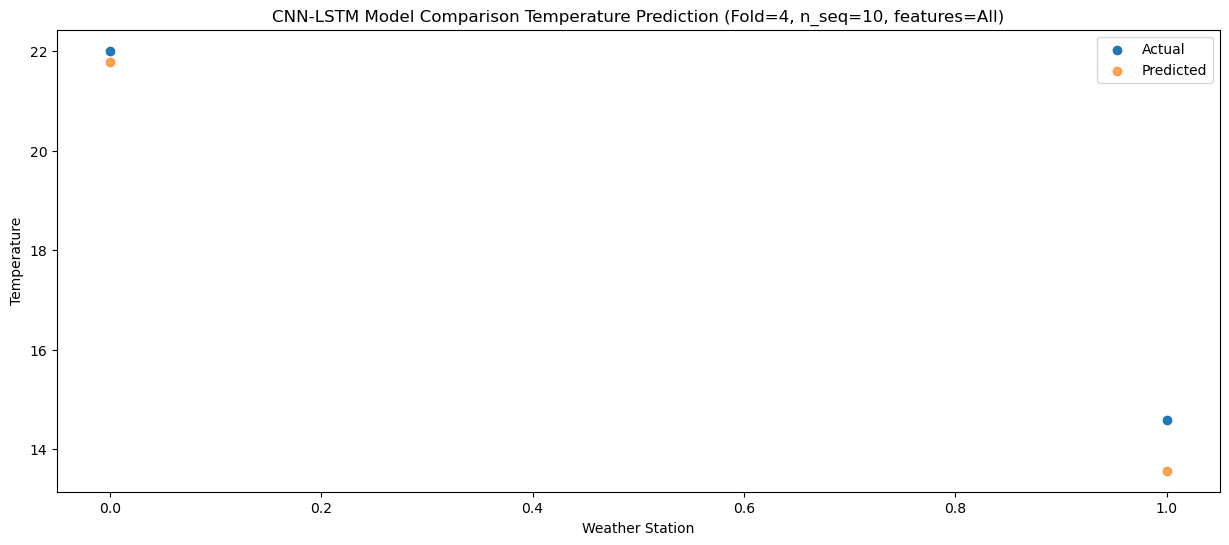

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   22.53  22.629175
1                1   15.60  14.445483


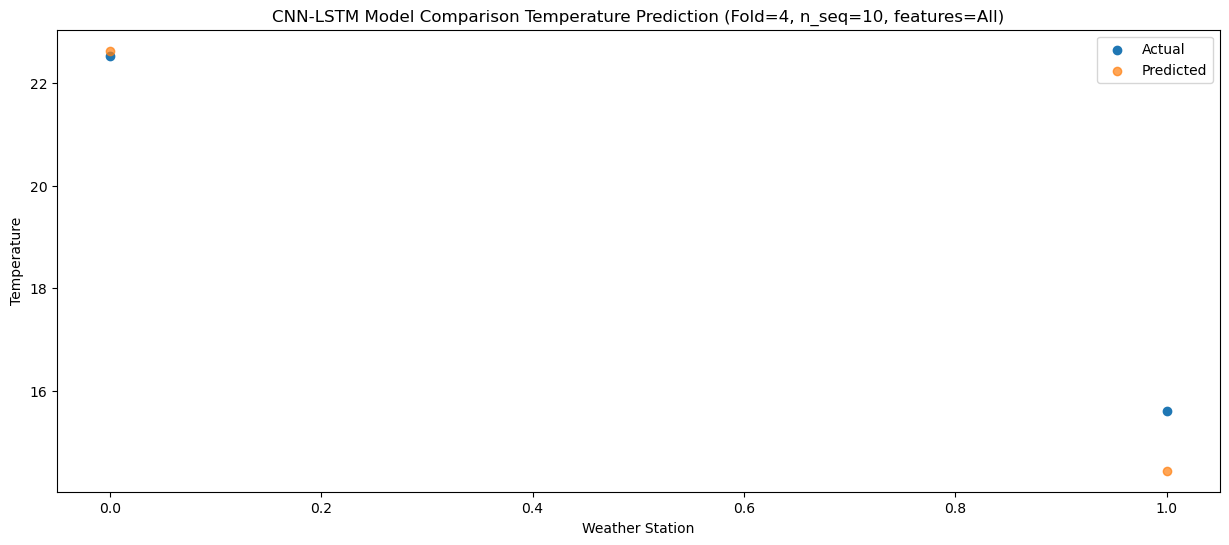

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   22.73  22.667212
1                1   15.53  14.486069


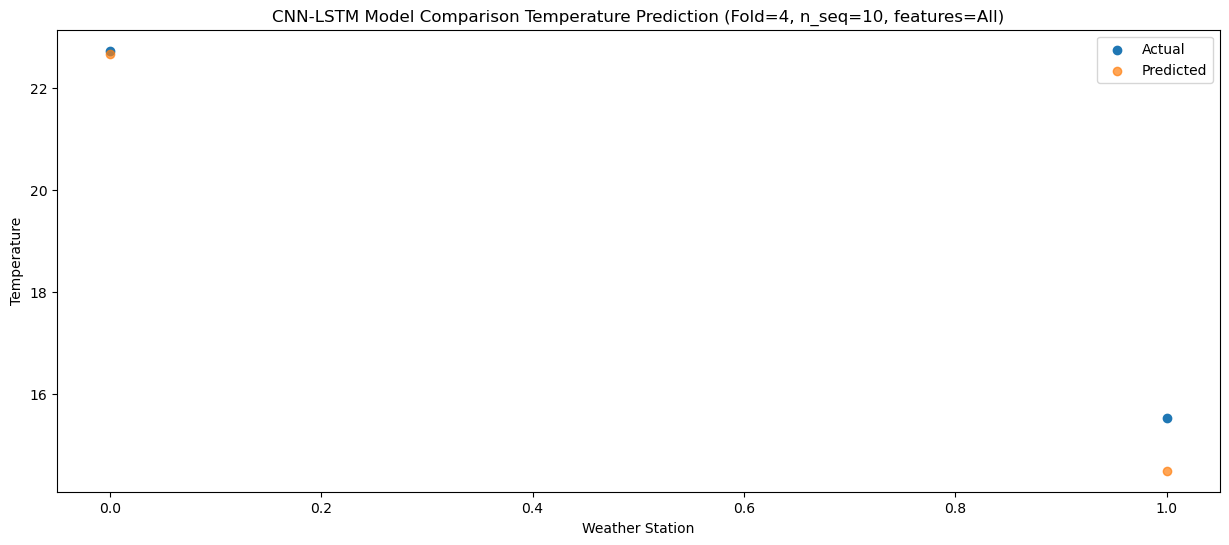

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.89  21.766451
1                1   14.23  13.612285


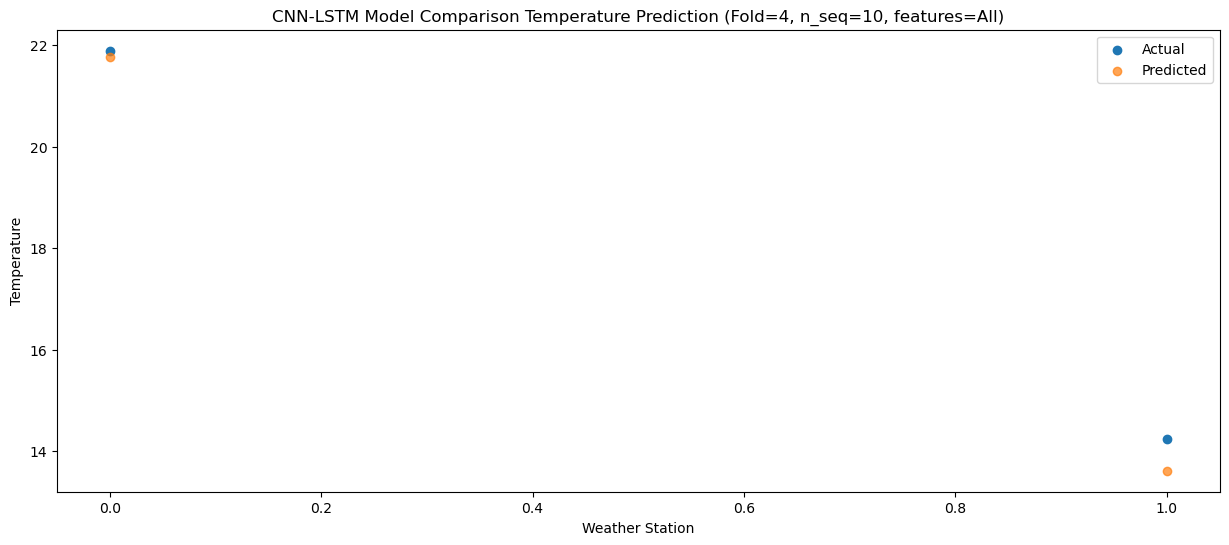

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   21.76  21.865466
1                1   13.53  13.742258


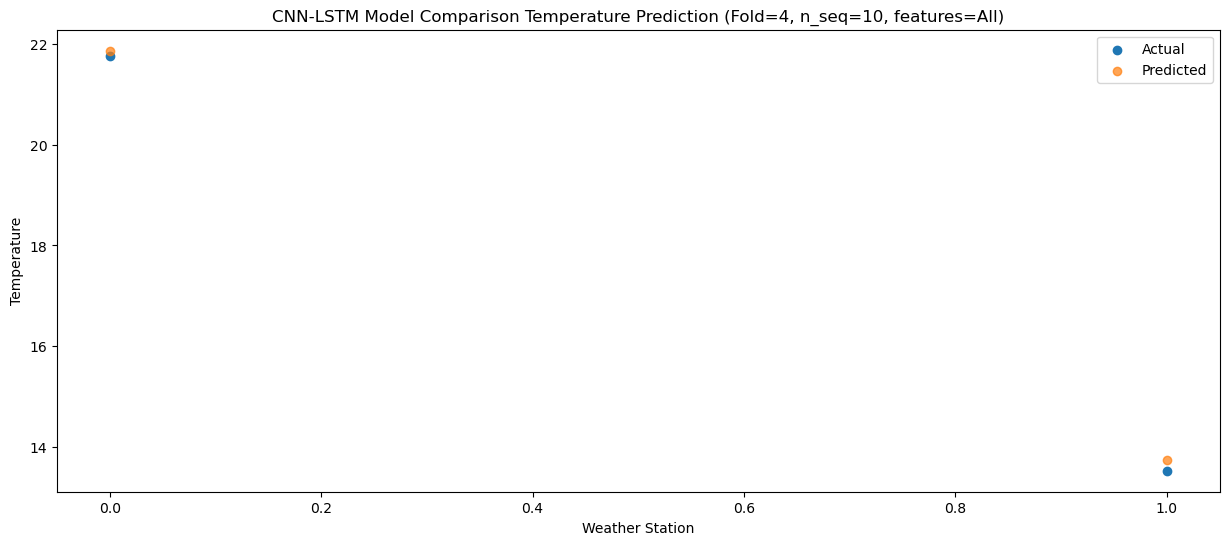

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   22.28  22.165313
1                1   14.09  14.058866


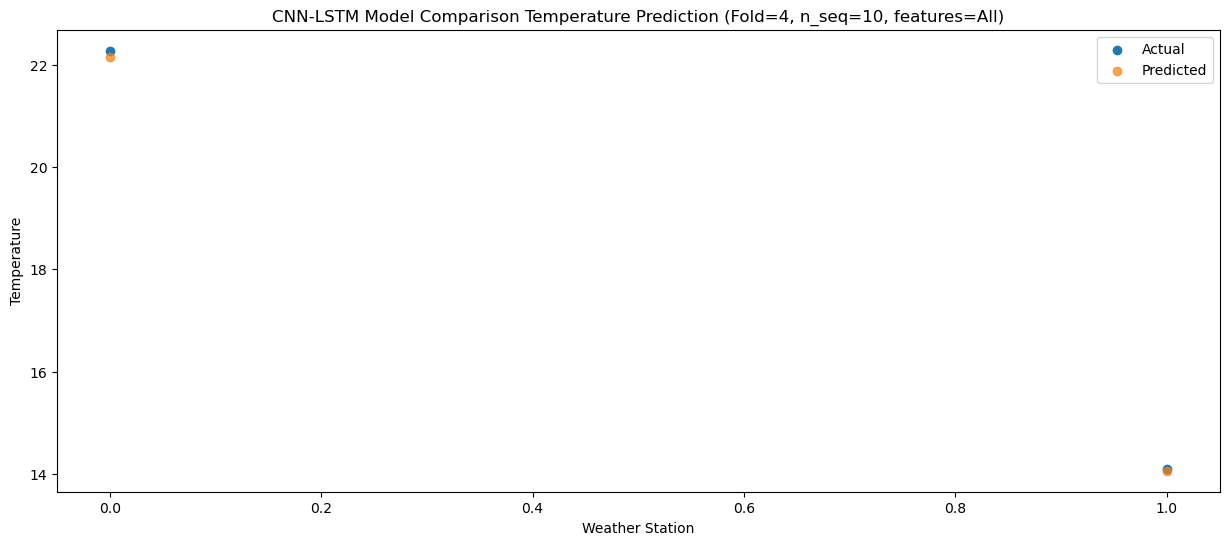

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   21.86  22.102513
1                1   14.41  14.026561


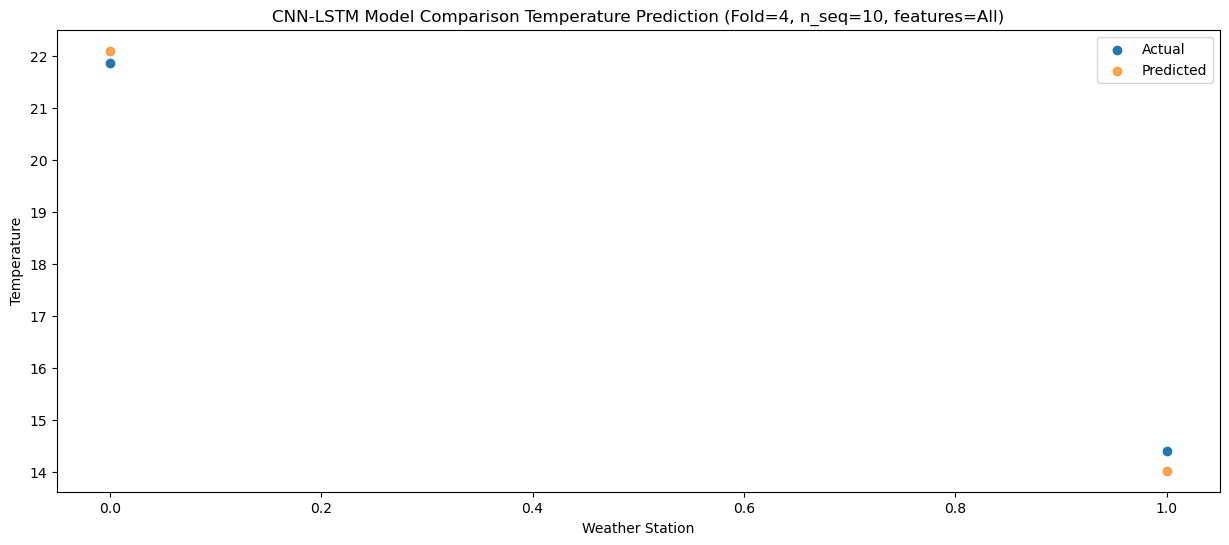

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   22.36  21.970698
1                1   13.54  13.891411


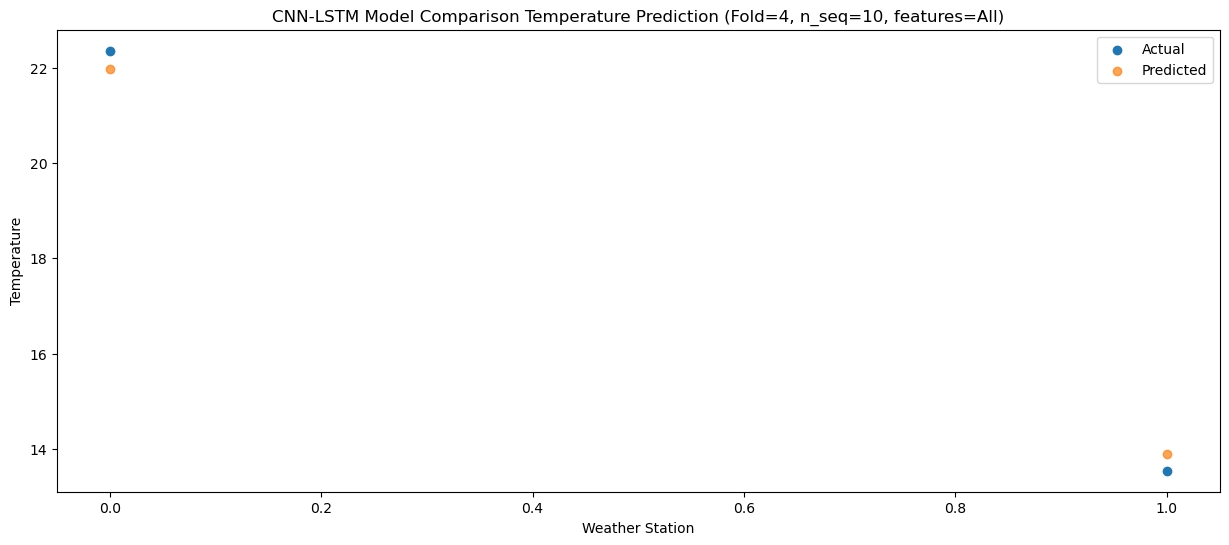

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   23.29  22.535926
1                1   15.02  14.462739


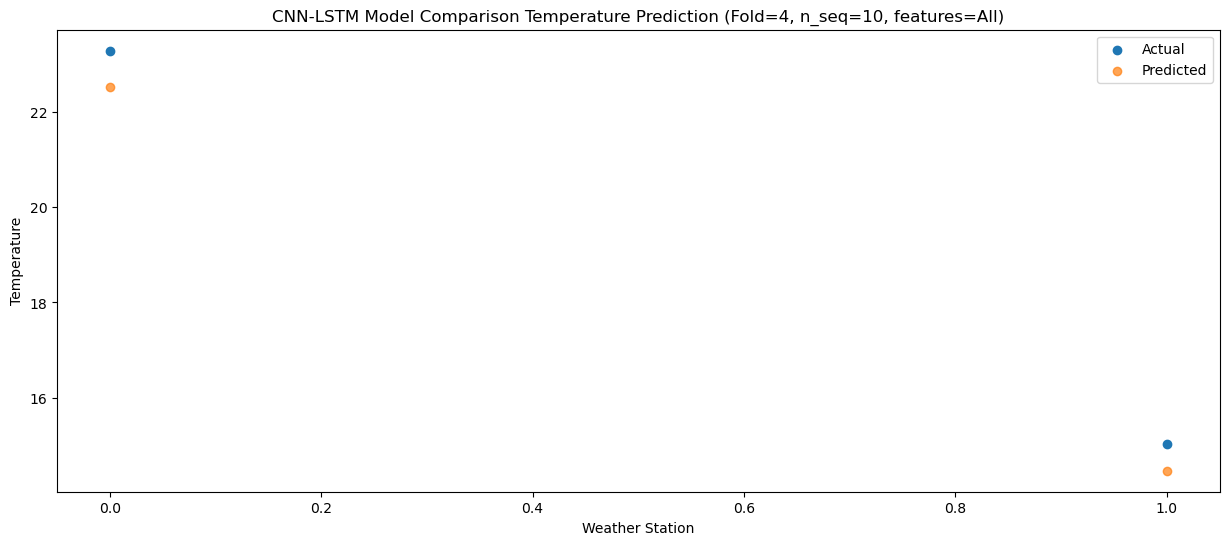

f, t:
[[21.14 12.63]
 [22.01 14.58]
 [22.53 15.6 ]
 [22.73 15.53]
 [21.89 14.23]
 [21.76 13.53]
 [22.28 14.09]
 [21.86 14.41]
 [22.36 13.54]
 [23.29 15.02]]
[[20.7218215  12.4863013 ]
 [21.77808805 13.5683788 ]
 [22.62917454 14.44548284]
 [22.66721215 14.48606878]
 [21.76645078 13.61228495]
 [21.86546625 13.74225848]
 [22.1653132  14.05886617]
 [22.10251313 14.02656091]
 [21.9706983  13.89141095]
 [22.53592598 14.46273858]]
Year at t+1:
t+1 SKRMSE: 0.312668
t+1 KRMSE: 0.312668
t+1 MAE: 0.280939
t+1 SKMAPE: 0.015579
t+1 R2_SCORE: 0.994600
t+1 KMAPE: 0.015579
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.733880
t+2 KRMSE: 0.733880
t+2 MAE: 0.621767
t+2 SKMAPE: 0.039960
t+2 R2_SCORE: 0.960976
t+2 KMAPE: 0.039960
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.819373
t+3 KRMSE: 0.819373
t+3 MAE: 0.626846
t+3 SKMAPE: 0.039205
t+3 R2_SCORE: 0.944081
t+3 KMAPE: 0.039205
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.739505
t+4 KRMSE: 0.739505
t+4 MAE: 0.553360
t+4 SKMAPE: 0.034991
t+4 R

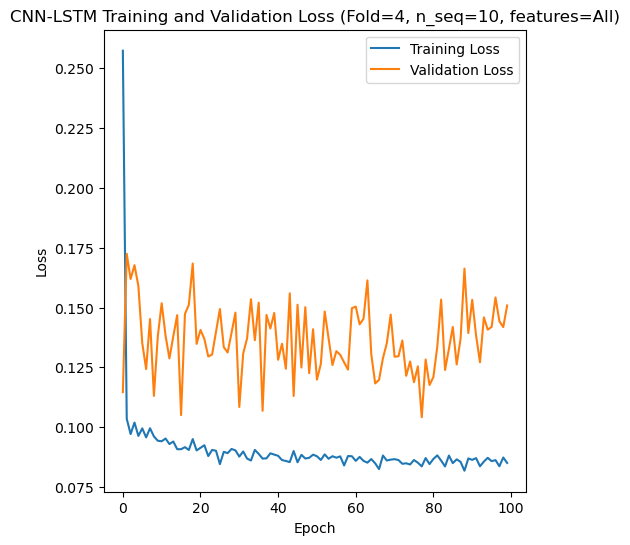

[[0.5575150521975817], [0.7872825739801522], [0.5488554743359736], [1.02986136580173], [0.5261345054604966]]
[[array(0.55751505)], [array(0.78728257)], [array(0.54885547)], [array(1.02986137)], [array(0.52613451)]]
[[0.3834882086236032], [0.6386224048137661], [0.44990041149407667], [0.9012966156080363], [0.4024315541759133]]
[[0.0199768355792155], [0.031822269690625696], [0.026490386332503703], [0.060001578067955565], [0.02434817097154795]]
[[0.9262166564173169], [-1.7540427773212586], [0.9199892027936719], [-1.7201187766582433], [0.9827310736373029]]
[[array(0.01997684)], [array(0.03182227)], [array(0.02649039)], [array(0.06000158)], [array(0.02434817)]]
[[array(0.93903086)], [array(0.27388634)], [array(0.97893345)], [array(0.22894404)], [array(0.98938906)]]
[20.39 21.69 22.42 22.78 21.56 21.49 21.66 21.49 21.73 22.15 16.37 17.64
 17.8  18.04 18.   18.95 18.12 17.61 17.89 17.72 19.63 20.16 20.45 20.41
 20.24 20.32 20.41 19.49 19.83 20.67 19.88 19.4  20.43 20.81 19.96 20.09
 20.61 20.2

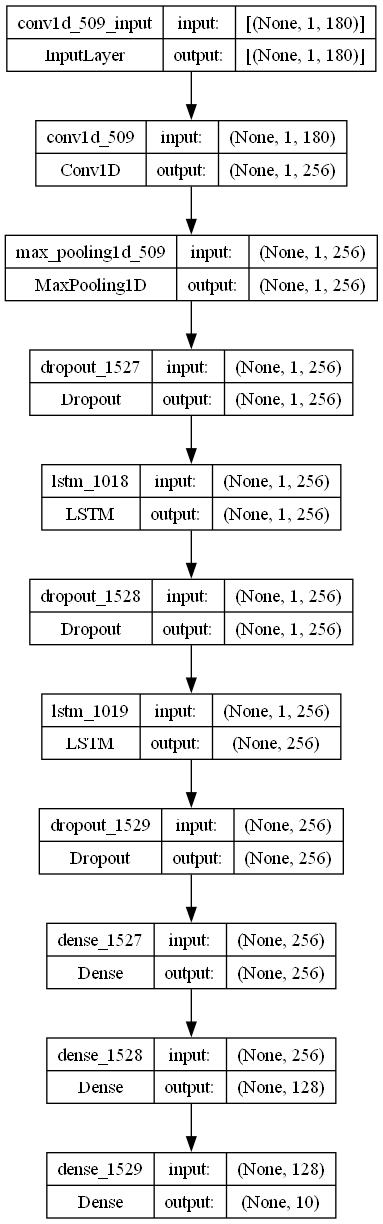

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 256
    lr = 0.24073610196074202
    optimizer = SGD(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 256
    dropout_rate = 0.13556613147324922

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)                        
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_CV_S10.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)